Authors: 

- Sarah Olesen 
- Tim Sit

In [88]:
# aesthetics 
def aesthetics(font_scale = 1.25, line_width = 2.5):
    import matplotlib as mpl
    mpl.rcParams['figure.dpi']= 300
    sns.set_context("notebook", font_scale= font_scale, rc={"lines.linewidth": line_width})
    sns.set_style('white')
    # label with LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc("axes.spines", top=False, right=False)
    
aesthetics()

# Passive Properties

## Make a ball model 

and measure $R_i$, $m_\tau$ with current injection

We first define the function for creating a cell, injecting current, and recording voltage over time.

In [81]:
%reset -f

from neuron import h, gui
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# default somalength = 100
# default soma diam = 500 
def inject_current(cell, somaLength = 12.54, somaDiam = 12.54, 
                   stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25, 
                   g_pas = 0.001,
                  printProperties = False): 
    """
    Injects current to a cell and measure the voltage over time
    INPUT 
    somaLength      | length of the soma (um)
    somaDiam        | diameter of the soma 
    stimDur         | duration of the stimulus (ms)
    stimAmp         | amplitude of current injection (pA)
    stimDelay       | delay before the stimulus is given (ms)
    total_time      | total time of the simulation 
    printProperties | if true, print the properties of the cell 
    OUTPUT 
    voltage 
    time
    """
    
    cell.insert('pas')
    cell.L = somaLength 
    cell.diam = somaDiam
    cell.g_pas = 0.001
    
    if printProperties is True:
        print('Cell properties')
        h.psection()
    
    # add point process: current injection 
    stim = h.IClamp(cell(0.5))
    stim.delay = stimDelay
    stim.dur = stimDur # ms
    stim.amp = stimAmp # nA

    # measure voltage
    voltage = h.Vector() 
    voltage.record(cell(0.5)._ref_v)
    
    # measure time
    time = h.Vector()
    time.record(h._ref_t)
    
    h.v_init = -70 # initial voltage
    h.load_file('stdrun.hoc')
    h.tstop = total_time
    h.run() # ms
    
    # time_np = time.as_numpy() # WARNING: don't output values with .as_numpy()
    # voltage_np = voltage.as_numpy()
    
    return voltage, time

We define a function to calculate the input resistance ($R_i$), from our cell recording using 

$$
R_i = \frac{\Delta V}{\Delta I_e}
$$




In [82]:
def cal_Ri(voltage_np, stimAmp = 0.05):
    
    delta_V = (max(voltage_np) - min(voltage_np)) * 10**(-3) # millivolts (mV)
    delta_Ie = stimAmp * 10**(-9) # nanoAmps
    input_resistance = delta_V / delta_Ie
    
    return input_resistance

We also define a function to calculate the membrane time constant $\tau_m$ from our recording. We are doing this by finding the time when the voltage has reached 63.2% of its peak voltage.



In [94]:
def cal_TauM(voltage, time, stimDelay = 10):
    # convert voltage to numpy 
    voltage_np = voltage.as_numpy()
    time_np = time.as_numpy()
    # from "experiment"
    special_v = (max(voltage_np) - min(voltage_np)) * (1 - 1/np.e)
    special_vv = special_v + min(voltage_np)

    tauIndex = np.where(np.logical_and(voltage_np > special_vv - 0.05, voltage_np < special_vv + 0.05))
    if tauIndex[0].size > 1: # more than one matching value
        tau_m_samp = tauIndex[0][0]
    else: 
        tau_m_samp = tauIndex[0]

    tau_m_exp = time_np[tau_m_samp]
    TauM = tau_m_exp - stimDelay
    
    return TauM

Input resistance is 202410369.26 ohms
Input resistance is 202.41 Mohms
TauM is 1.00 ms


"\ncolor = 'tab:blue'\nax2.set_ylabel('Percentage of maximum voltage (%)', color=color)  # we already handled the x-label with ax1\nax2.plot(t, data2, color=color)\nax2.tick_params(axis='y', labelcolor=color)\n\nfig.tight_layout()  # otherwise the right y-label is slightly clipped\n"

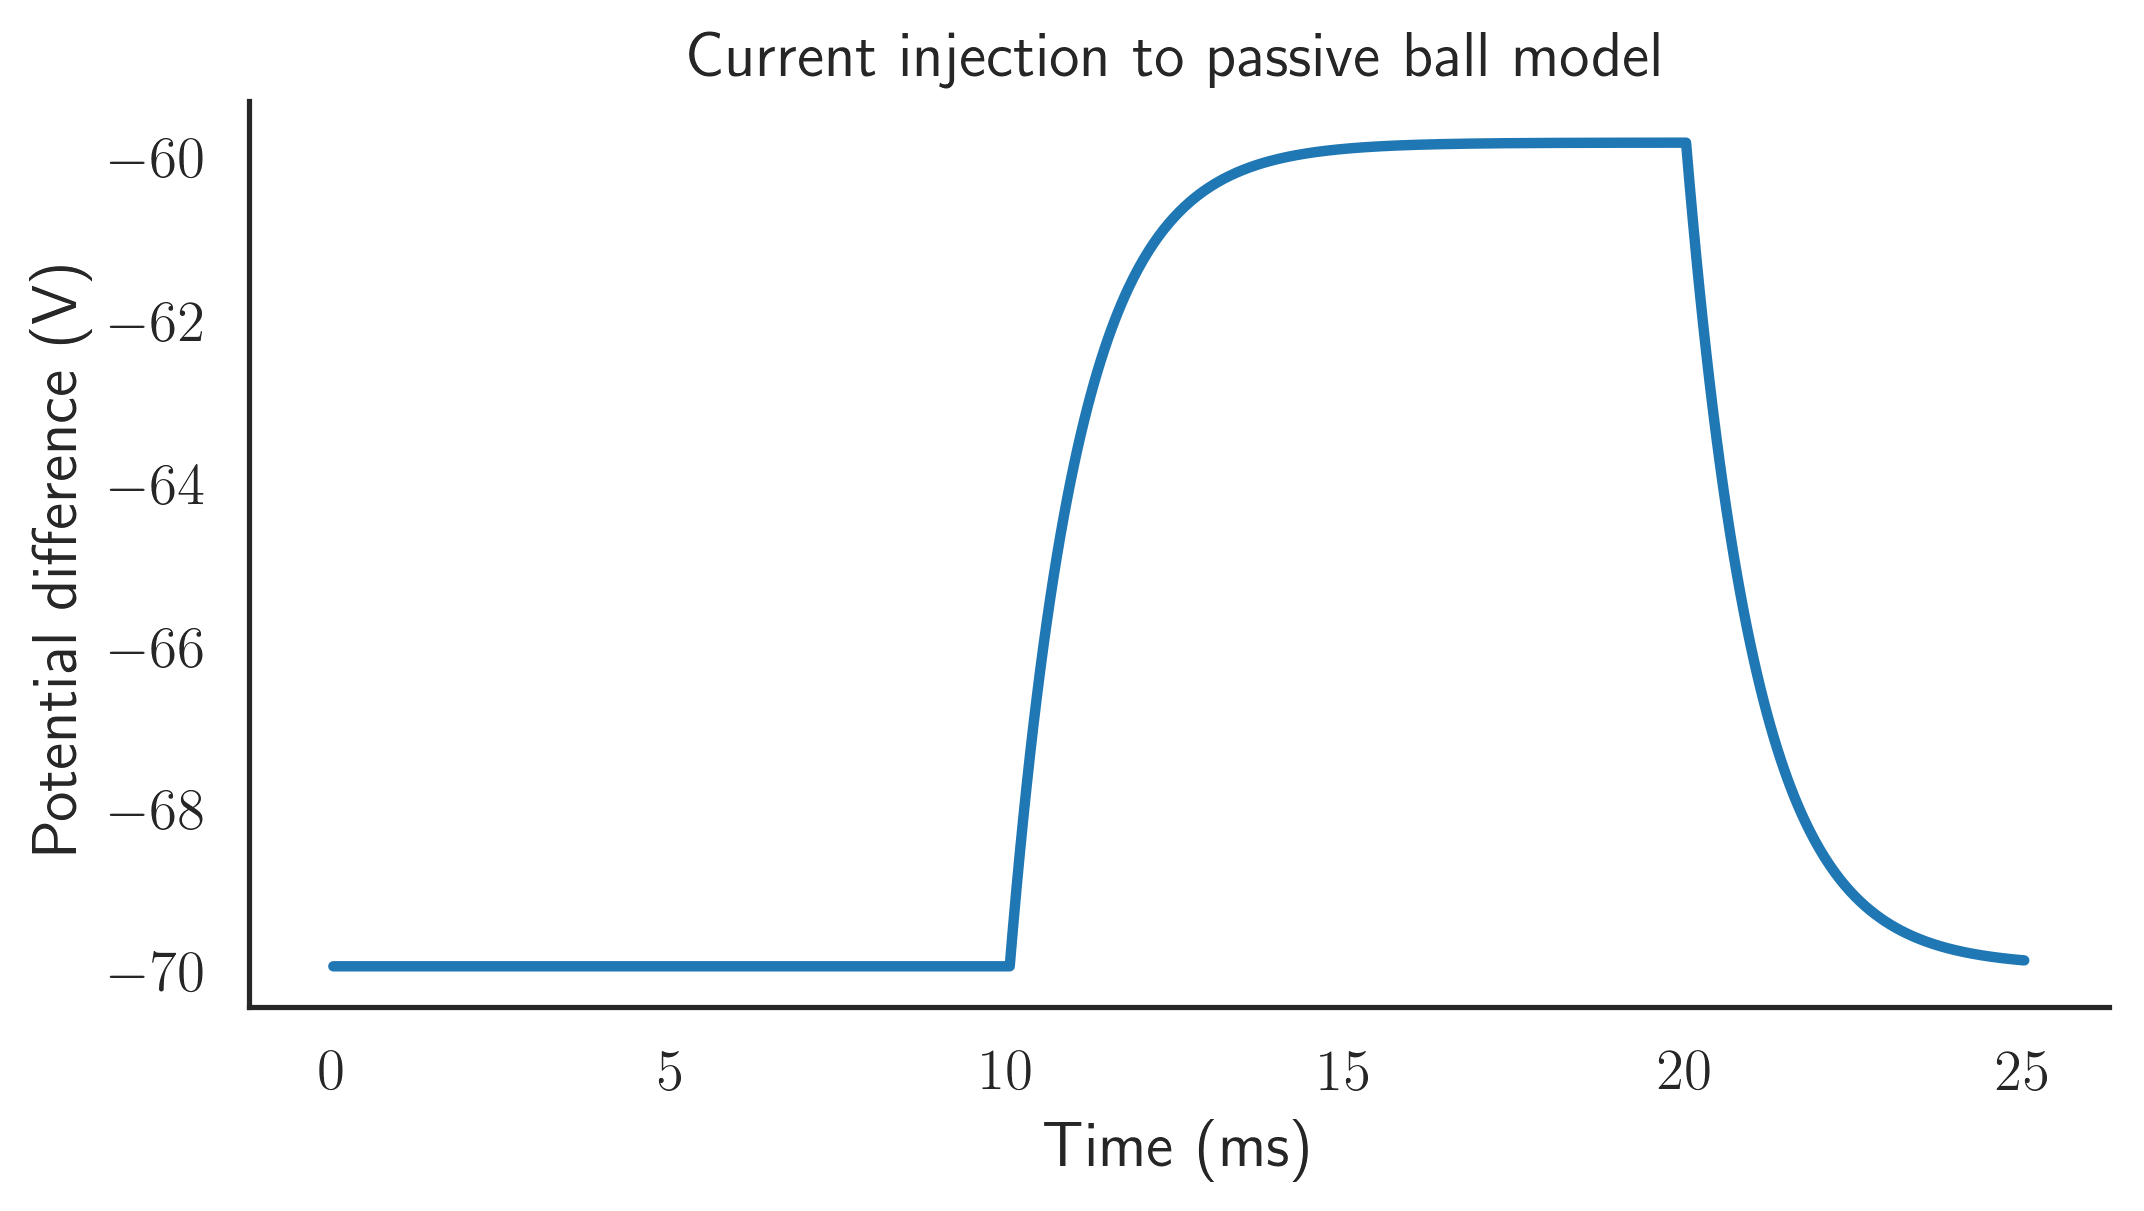

In [95]:
# test run 
voltage, time = inject_current(cell = h.Section(name='soma'))

plt.figure(figsize=(8, 4))
ax = sns.lineplot(time, voltage)
ax.set_title('Current injection to passive ball model')
ax.set(xlabel='Time (ms)', ylabel='Potential difference (V)')

input_resistance = cal_Ri(voltage)
#  print('Input resistance is %.2f ohms' % input_resistance)
print('Input resistance is %.2f Mohms' % (input_resistance / 10**6))

TauM = cal_TauM(voltage, time)
print('TauM is %.2f ms' % TauM)

# TODO look into verifying by plotting TauM and showing the potential difference in the graph
# ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 
# still need to think about how to draw x and y lines 

# will be a good idea to add an extra y-axis showing the percentage to the max. voltage
# https://matplotlib.org/gallery/api/two_scales.html
"""
color = 'tab:blue'
ax2.set_ylabel('Percentage of maximum voltage (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
"""

Due to the cells small size the input resistance is greater than we would normally expect. During our in vitro experiments this week we measured our input resistance to be around 5 Mohms.  

## Varying neuron variables

Change diameter, $R_m$, $R_a$, $C_m$ and see how it affects $R_i$ and $m_\tau$


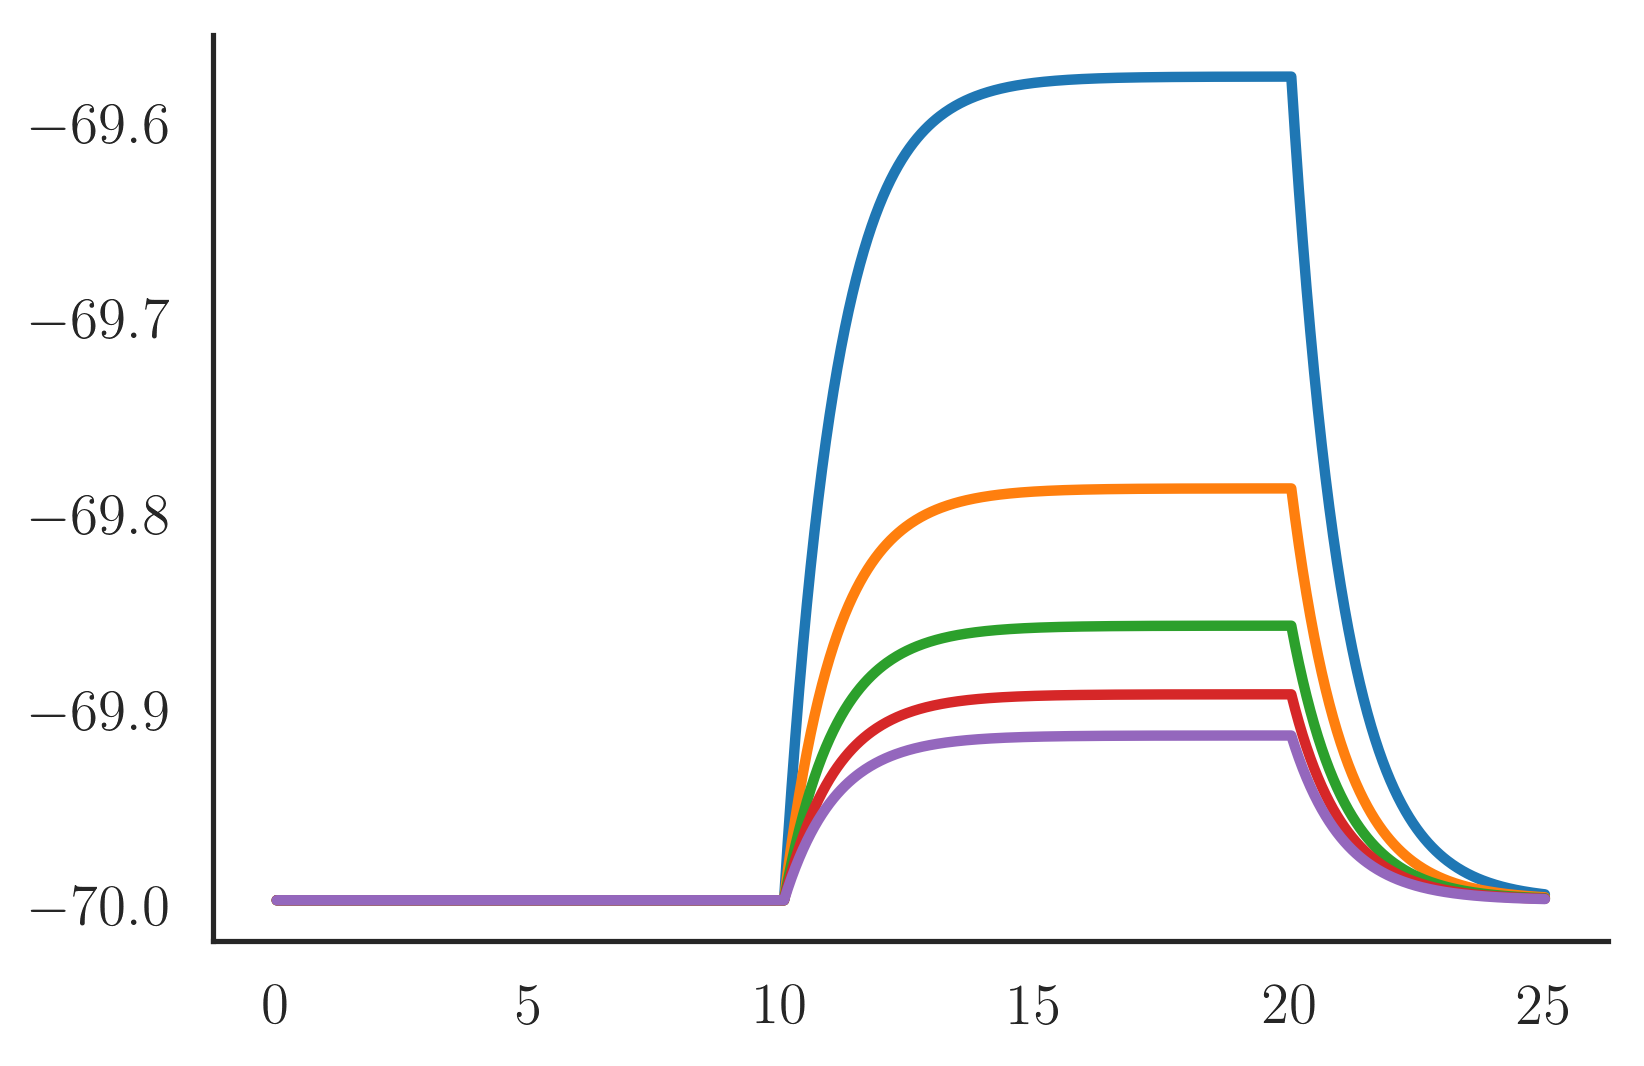

In [96]:
# diam_list = [5, 10, 15, 20]
g_list = [0.001, 0.01, 0.1, 1, 10]
Ra_list = [10, 20, 30, 40, 50] # default is 35.4 
diam_list = [300, 600, 900, 1200, 1500] # default is 500
Cm_list = [0.1, 0.3, 0.6, 1.0, 1.3] # default is 1
# circum =  soma.diam  * np.pi 
# length = soma.L
# A_list = (circum * 10**(-6)) * (length * 10 ** (-6)) 
# Ri_list = 

input_resistance_list = list()
TauM_list = list()

for diam in diam_list:
    voltage_np, time_np = inject_current(cell = h.Section(name='soma'), somaLength = 12.6157,
somaDiam = diam, stimDur = 10, stimAmp = 0.05, stimDelay = 10)
    input_resistance_list.append(cal_Ri(voltage_np))
    TauM_list.append(cal_TauM(voltage_np, time_np))
    # plot voltage over time 
    plt.plot(time_np, voltage_np)

plt.show()

# print(input_resistance_list)
# print(TauM_list)

### Variation of input reistance and time constant with diameter

[Text(0, 0.5, 'Input resistance ($\\Omega$)'),
 Text(0.5, 0, 'Diameter ($\\mu$m)')]

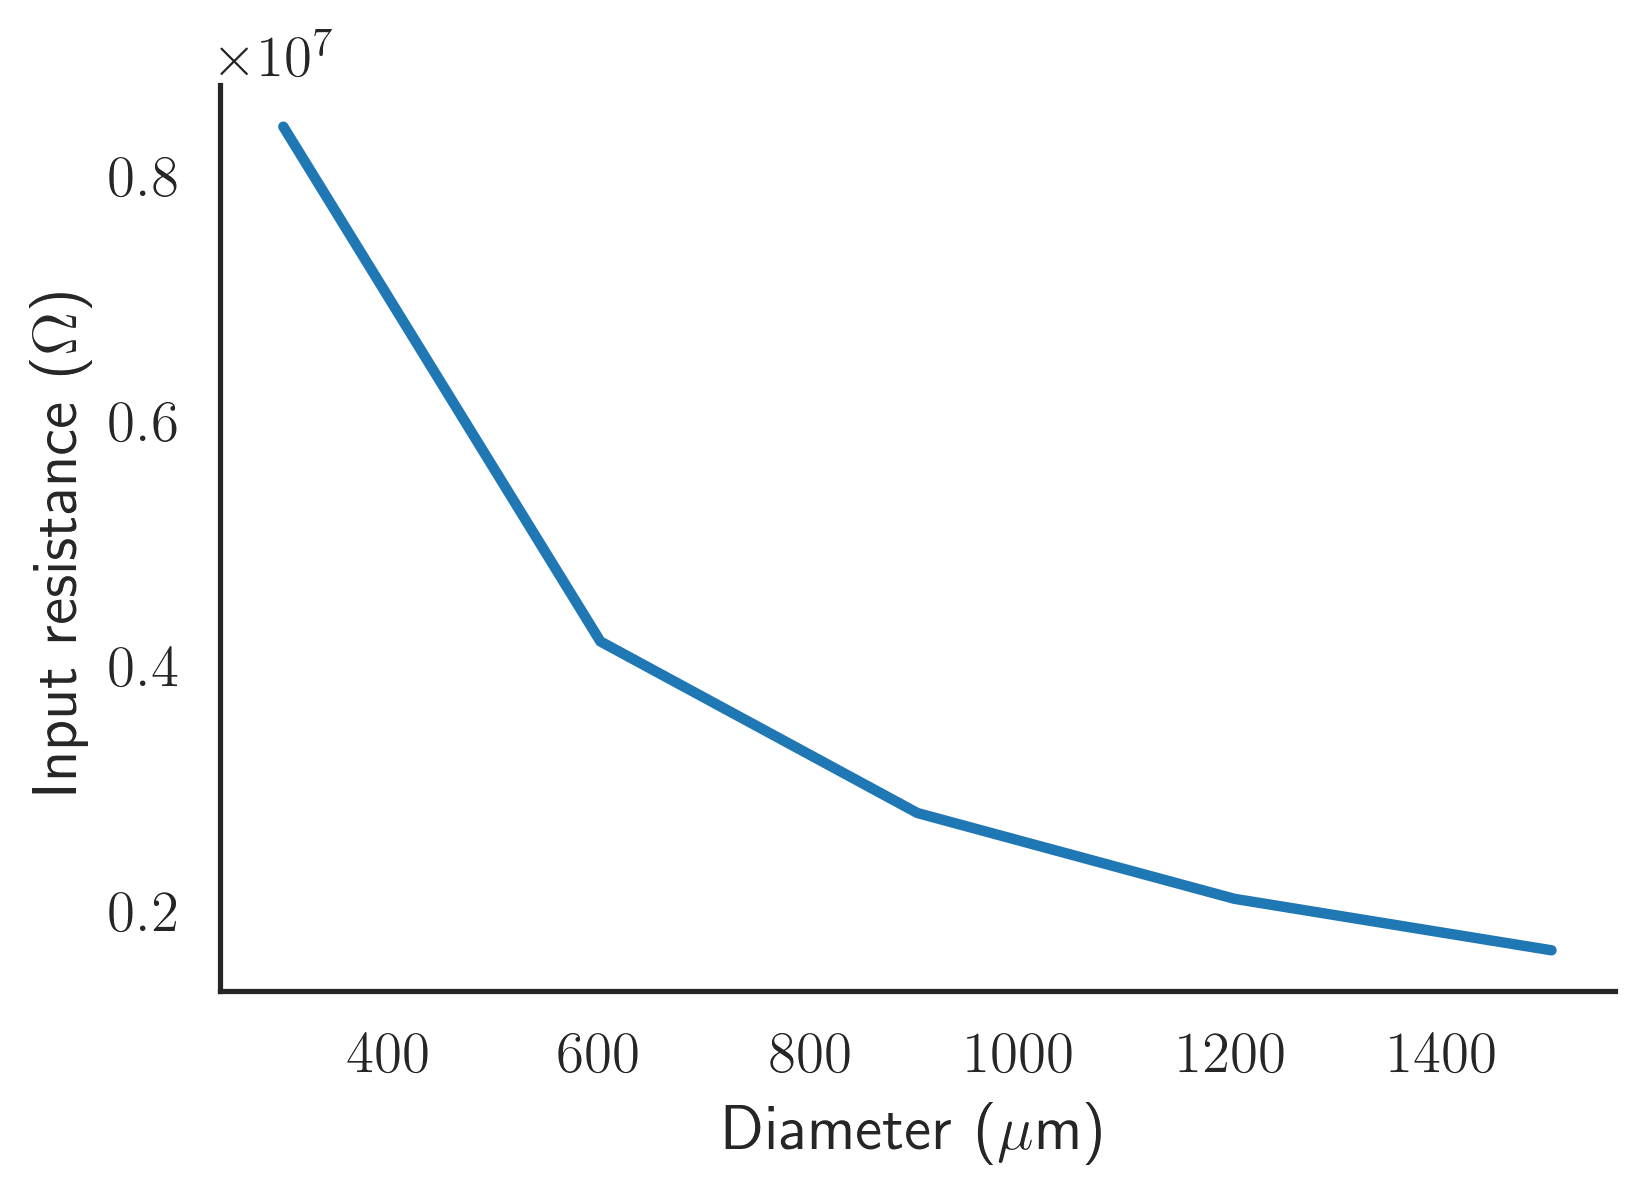

In [97]:
import seaborn as sns 
aesthetics()
ax = sns.lineplot(diam_list, input_resistance_list)
ax.set(xlabel='Diameter ($\mu$m)', ylabel='Input resistance ($\Omega$)')

[Text(0, 0.5, 'Time constant (ms)'), Text(0.5, 0, 'Diameter ($\\mu$m)')]

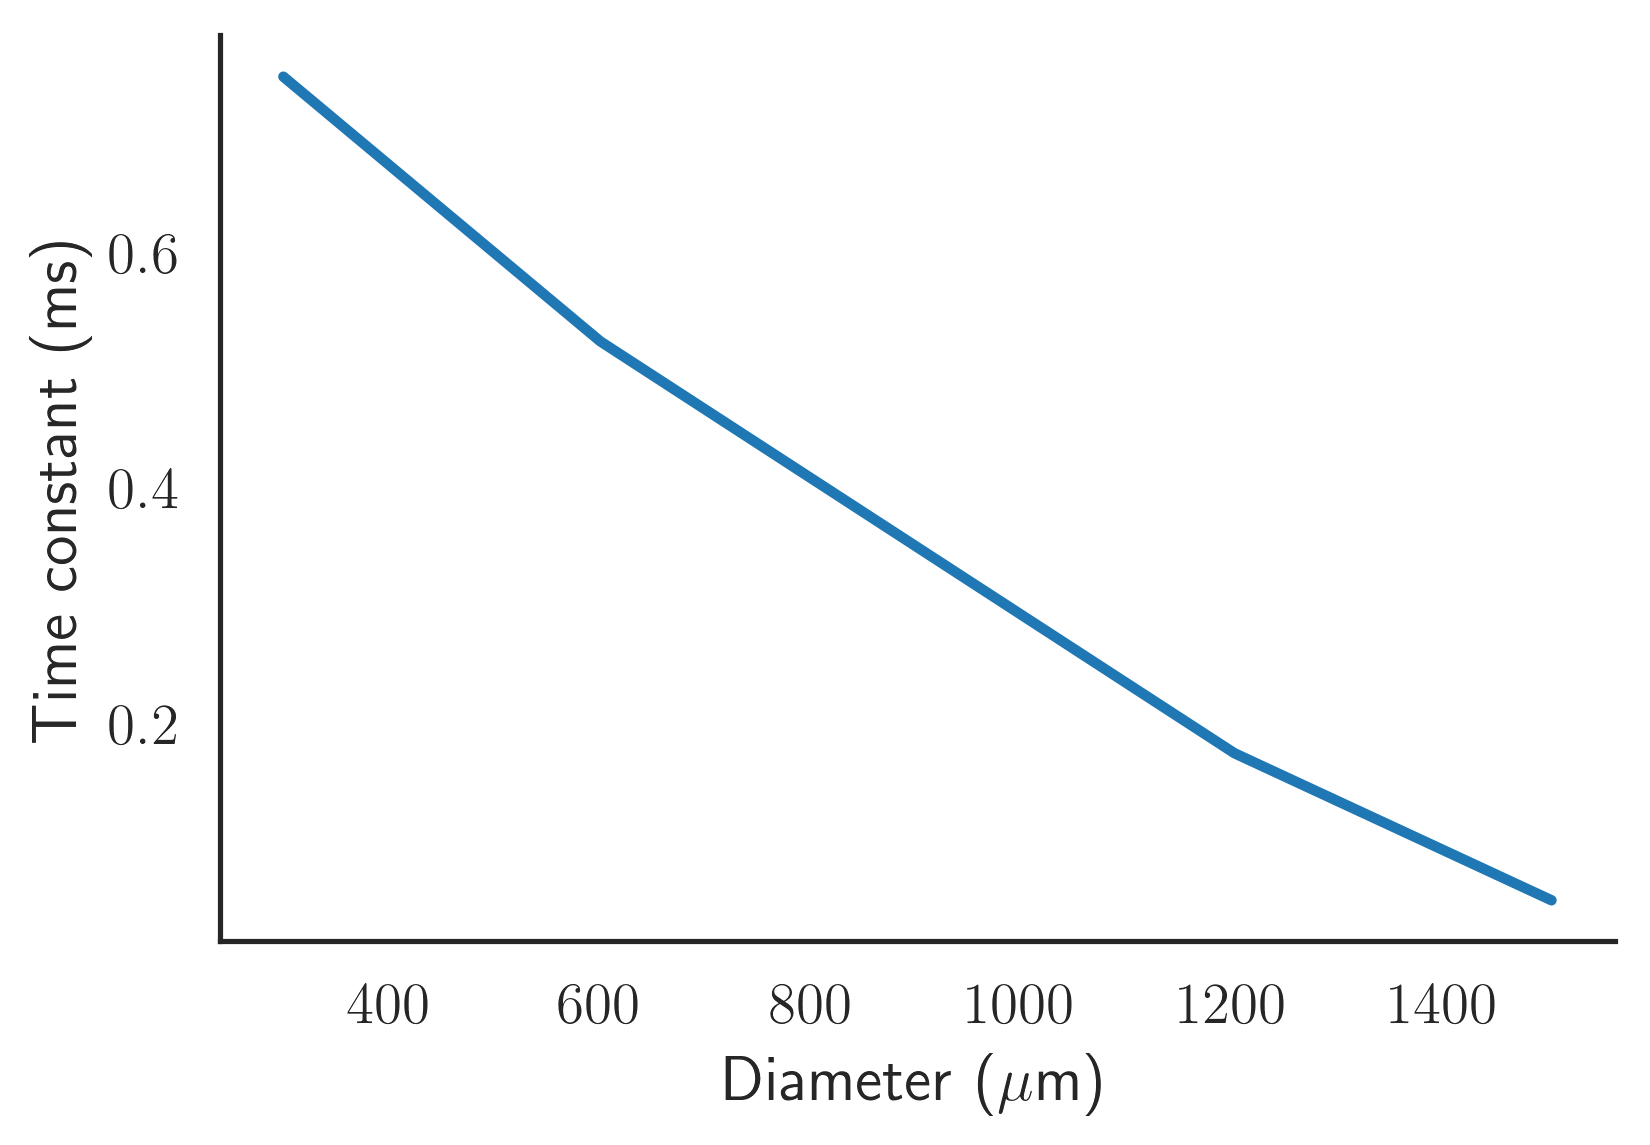

In [98]:
# time constant vs. diameter 
ax2 = sns.lineplot(diam_list, TauM_list)
ax2.set(xlabel='Diameter ($\mu$m)', ylabel='Time constant (ms)')

### Varying all variables

In [37]:
import itertools
import pandas as pd
# variable lists
# Rm_list = [0.001, 0.01, 0.1, 1, 10] # can't do this in NEURON, this is dependent on Ra
# Ra_list = [10, 20, 30, 40, 50]
diam_list = [3, 6, 9, 12, 15]
Cm_list = [0.1, 0.3, 0.6, 1.0, 1.3]
Ri_list = list()
mTau_list = list()

# using ranges 
Ra_list = np.arange(10, 50, 2)
Cm_list = np.arange(0.1, 1.3, 0.1)


# varying all 3 variables
# variableCart, variableIter = itertools.tee(itertools.product(Ra_list, diam_list, Cm_list))
# cartesian product of the variables
# using tee to make two copies of the same iterator so I can use it twice

# varying just 2 variables 
diam = 3
variableCart, variableIter = itertools.tee(itertools.product(Ra_list, Cm_list))


# df = pd.DataFrame(list(variableCart),
#                   columns = ['Ra', 'Diam', 'Cm'])

df = pd.DataFrame(list(variableCart),
                  columns = ['Ra', 'Cm'])

for var_list in variableIter:
    cell = h.Section(name = 'cell')
    # 3 variables
    # cell.Ra = var_list[0] # axial resistance
    # diam = var_list[1]
    # cell.cm = var_list[2]
    
    # 2 variables 
    cell.Ra = var_list[0]
    cell.cm = var_list[1]
    diam = 50000 # default to 500
    
    voltage, time = inject_current(cell = cell, somaLength = 12.6157,
somaDiam = diam, stimDur = 10, stimAmp = 0.05, stimDelay = 10)
    Ri_list.append(cal_Ri(voltage))
    mTau_list.append(cal_TauM(voltage, time))

df['Ri'] = Ri_list
df['mTau'] = mTau_list
    
# print preview of the table
# df

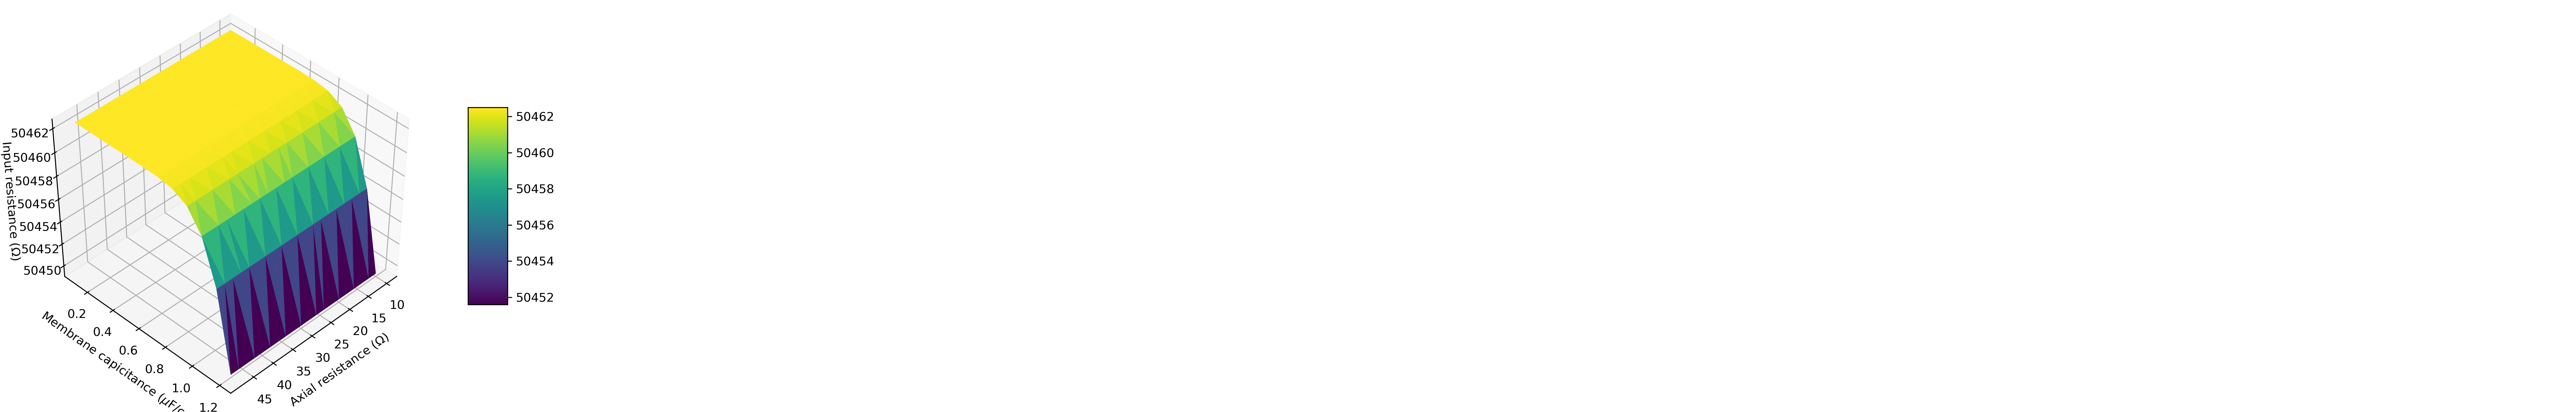

In [34]:
# 3D surface plot to show the effect of the 2 variables on input resistance 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Make the plot
fig = plt.figure(figsize=(8, 6), dpi = 300)
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Ra'], df['Cm'], df['Ri'], cmap=plt.cm.viridis, linewidth=0.2)
ax.set(xlabel='Axial resistance ($\Omega$)', ylabel='Membrane capicitance ($\mu$F/cm$^2$)',
      zlabel = 'Input resistance ($\Omega$)')
# plt.show()
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['Ra'], df['Cm'], df['Ri'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()
 
# Rotate it
ax.view_init(45, 45)
plt.show()

In [55]:
# varying the diameter and the membrane capacitance 
# Cm_list = np.arange(0.1, 1.3, 0.1)
conductance_list = np.arange(0.001, 100, 1) # default g_pas =0.001
diam_list = np.arange(250, 250.5, 0.01) # default diam = 500

# lists to store input resistance and time constant
Ri_list = list()
mTau_list = list()


variableCart, variableIter = itertools.tee(itertools.product(conductance_list, diam_list))

df = pd.DataFrame(list(variableCart),
                  columns = ['Conductance', 'Diameter'])

for var_list in variableIter:
    cell = h.Section(name = 'cell')
    
    # 2 variables 
    cell.insert('pas')
    cell.g_pas = var_list[0]
    diam = var_list[1]
    
    cell.cm = 1 # default capacitance 
    cell.Ra = 35.4 # default axial resistance
    
    voltage, time = inject_current(cell = cell, somaLength = 12.6157,
somaDiam = diam, stimDur = 10, stimAmp = 0.05, stimDelay = 10)
    Ri_list.append(cal_Ri(voltage))
    mTau_list.append(cal_TauM(voltage, time))

df['Ri'] = Ri_list
df['mTau'] = mTau_list



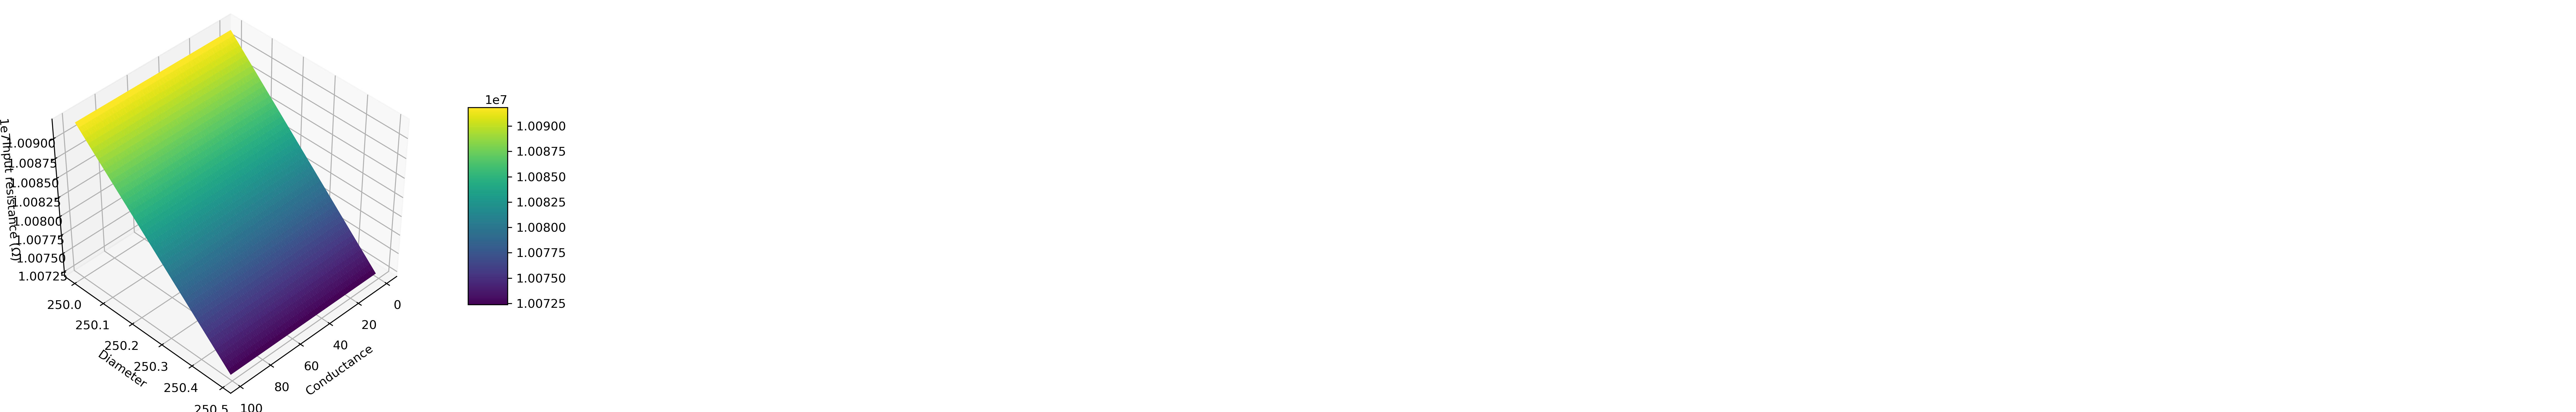

In [56]:
# 3D surface plot to show the effect of the 2 variables on input resistance 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Make the plot
fig = plt.figure(figsize=(8, 6), dpi = 300)
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Conductance'], df['Diameter'], df['Ri'], cmap=plt.cm.viridis, linewidth=0.2)
ax.set(xlabel='Conductance', ylabel='Diameter',
      zlabel = 'Input resistance ($\Omega$)')
# plt.show()
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['Conductance'], df['Diameter'], df['Ri'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()
 
# Rotate it
ax.view_init(45, 45)
plt.show()

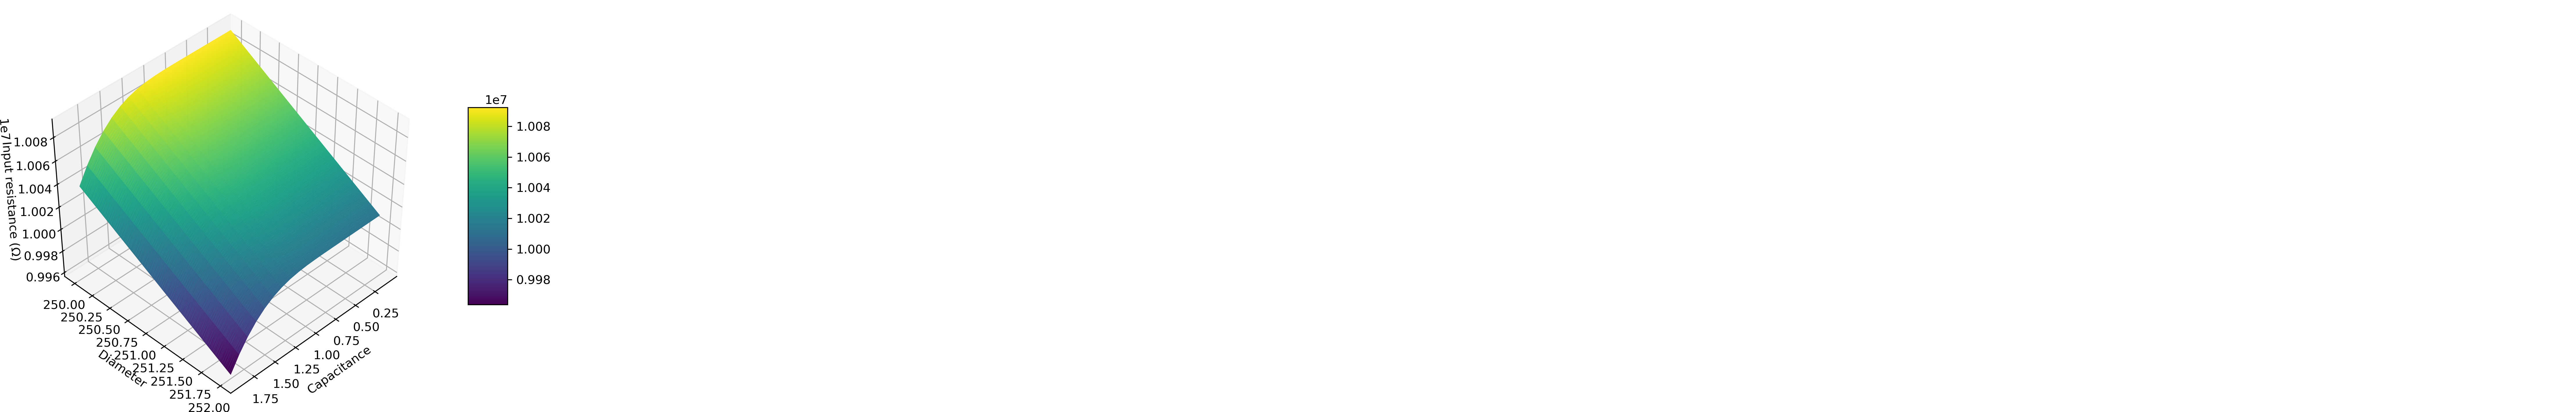

In [62]:
Cm_list = np.arange(0.1, 2, 0.1)
diam_list = np.arange(250, 252, 0.01) # default diam = 500

# lists to store input resistance and time constant
Ri_list = list()
mTau_list = list()


variableCart, variableIter = itertools.tee(itertools.product(Cm_list, diam_list))

df = pd.DataFrame(list(variableCart),
                  columns = ['Capacitance', 'Diameter'])

for var_list in variableIter:
    cell = h.Section(name = 'cell')
    
    # 2 variables 
    # cell.insert('pas')
    # cell.g_pas = var_list[0]
    # diam = var_list[1]
    
    cell.cm = var_list[0] # default capacitance 
    cell.Ra = 35.4 # default axial resistance
    diam = var_list[1]
    
    voltage, time = inject_current(cell = cell, somaLength = 12.6157,
somaDiam = diam, stimDur = 10, stimAmp = 0.05, stimDelay = 10)
    Ri_list.append(cal_Ri(voltage))
    mTau_list.append(cal_TauM(voltage, time))

df['Ri'] = Ri_list
df['mTau'] = mTau_list

# 3D surface plot to show the effect of the 2 variables on input resistance 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Make the plot
fig = plt.figure(figsize=(8, 6), dpi = 300)
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Capacitance'], df['Diameter'], df['Ri'], cmap=plt.cm.viridis, linewidth=0.2)
ax.set(xlabel='Capacitance', ylabel='Diameter',
      zlabel = 'Input resistance ($\Omega$)')
# plt.show()
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['Capacitance'], df['Diameter'], df['Ri'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()
 
# Rotate it
ax.view_init(45, 45)
plt.show()


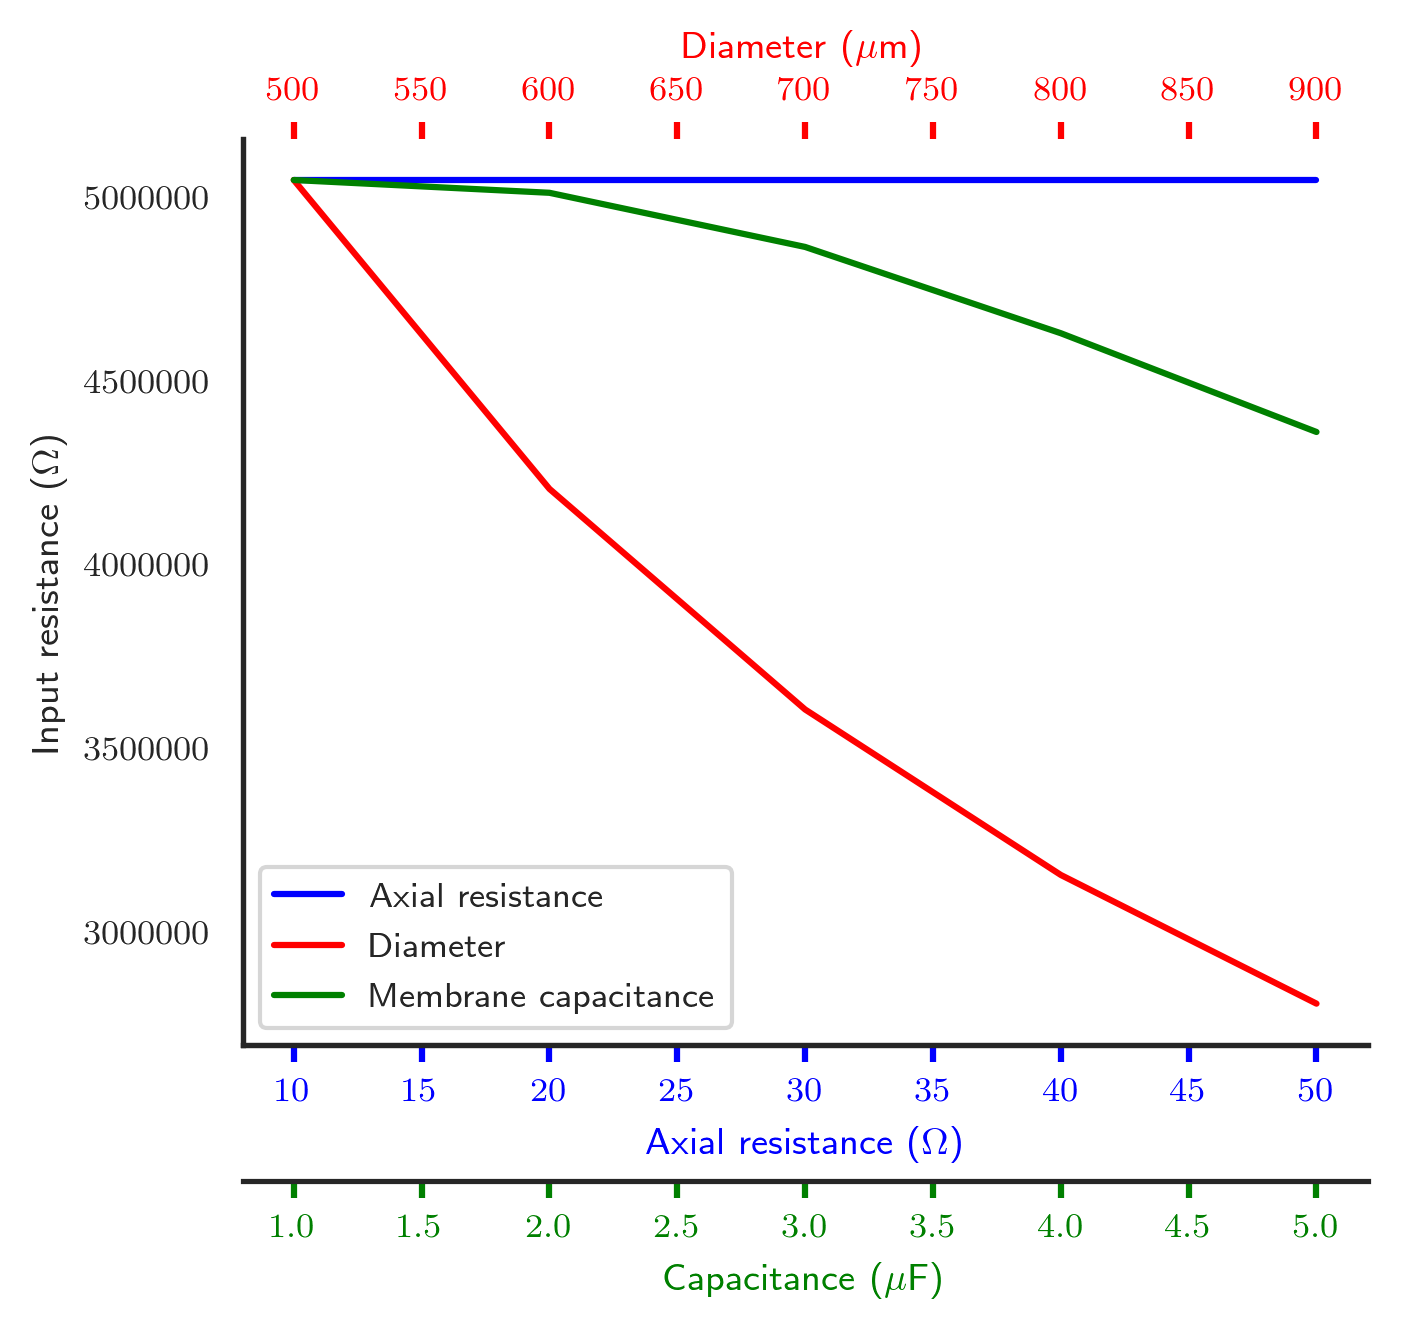

In [11]:
# based on: https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
# but instead of twinx, I am using twiny, and so the top rather than right axis is reset
import matplotlib.pyplot as plt

aesthetics(font_scale = 0.75, line_width = 1.5)

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twiny()
par2 = host.twiny()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
# par2.spines["right"].set_position(("axes", 1.2))
par2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
par2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom

par2.spines["bottom"].set_position(('axes', -0.15))

# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)

# Second, show the right spine.
# par2.spines["right"].set_visible(True)
par2.spines["bottom"].set_visible(True)

p1, = host.plot(Ra_list, Ri_Ra_list, "b-", label="Axial resistance")
p2, = par1.plot(diam_list, Ri_diam_list, "r-", label="Diameter")
p3, = par2.plot(Cm_list, Ri_Cm_list, "g-", label="Membrane capacitance")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.set_xlabel("Axial resistance ($\Omega$)")
host.set_ylabel("Input resistance ($\Omega$)")
# par1.set_ylabel("Input resistance")
# par2.set_ylabel("Velocity")
par1.set_xlabel('Diameter ($\mu$m)')
par2.set_xlabel('Capacitance ($\mu$F)')

host.xaxis.label.set_color(p1.get_color())
par1.xaxis.label.set_color(p2.get_color())
par2.xaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='x', colors=p1.get_color(), **tkw)
par1.tick_params(axis='x', colors=p2.get_color(), **tkw)
par2.tick_params(axis='x', colors=p3.get_color(), **tkw)
host.tick_params(axis='y', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

In [15]:
# another approach: plotting one variable against Ri and mTau
# based on: https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
import matplotlib.pyplot as plt

aesthetics(font_scale = 0.75, line_width = 0.75)

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
# par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
# make_patch_spines_invisible(par2)
# Second, show the right spine.
# par2.spines["right"].set_visible(True)

p1, = host.plot(Ra_list, Ri_Ra_list, "b-", label="Ri")
p2, = par1.plot(Ra_list, mTau_Ra_list, "r-", label="mTau")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.set_xlabel("Axial resistance")
host.set_ylabel("Input resistance")
par1.set_ylabel("Time constant")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

## Adding dendrites and axons with increasing total area

|-|       theSoma(0-1)
   `|       dendrite(0-1)

{'point_processes': {}, 'density_mechs': {}, 'ions': {}, 'morphology': {'L': 100.0, 'diam': [3.0], 'pts3d': [], 'parent': theSoma(1), 'trueparent': theSoma(1)}, 'nseg': 1, 'Ra': 35.4, 'cm': [1.0], 'regions': set(), 'species': set(), 'name': 'dendrite', 'hoc_internal_name': '__nrnsec_0x1f775a0', 'cell': None}
{'point_processes': {}, 'density_mechs': {}, 'ions': {}, 'morphology': {'L': 100.0, 'diam': [4.0], 'pts3d': [], 'parent': theSoma(1), 'trueparent': theSoma(1)}, 'nseg': 1, 'Ra': 35.4, 'cm': [1.0], 'regions': set(), 'species': set(), 'name': 'dendrite', 'hoc_internal_name': '__nrnsec_0x1f775a0', 'cell': None}
{'point_processes': {}, 'density_mechs': {}, 'ions': {}, 'morphology': {'L': 100.0, 'diam': [5.0], 'pts3d': [], 'parent': theSoma(1), 'trueparent': theSoma(1)}, 'nseg': 1, 'Ra': 35.4, 'cm': [1.0], 'regions': set(), 'species': set(), 'name': 'dendrite', 'hoc_internal_name': '__nrnsec_0x1f775a0', 'cell': None}
{'point_processes': 

[Text(0, 0.5, 'Time constant (ms)'),
 Text(0.5, 0, 'Dendrite diameter ($\\mu$m)')]

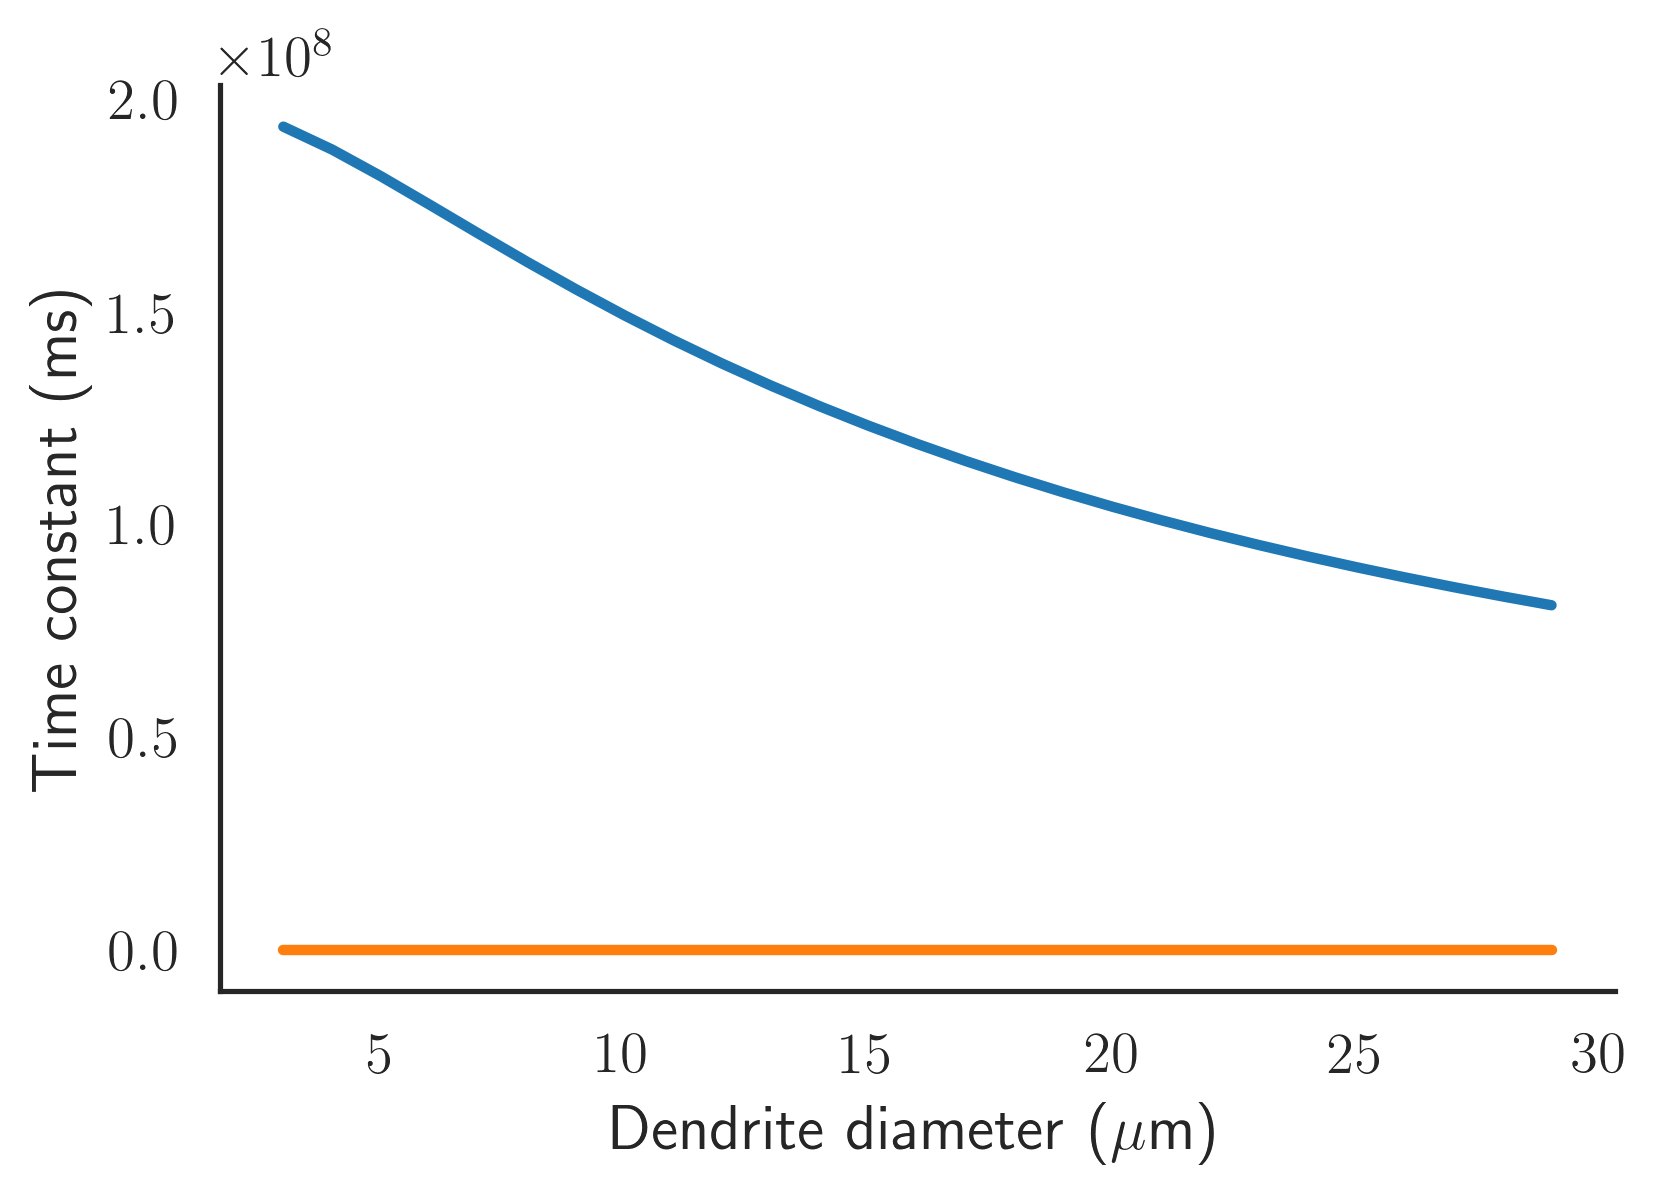

In [35]:
# import neuron 
from neuron import h, gui
# dendrite_diam_list = [3, 6, 9, 12, 15]
dendrite_diam_list = np.arange(3, 30)
axon_diam_list = [3, 6, 9, 12, 15] 
input_resistance_list = list()
TauM_list = list()

# neuron.h.delete_section(neuron.h.SectionLists)

theSoma = h.Section(name='theSoma') # set up a 'section'; abstract representation of a neuron, divided into segments
# all section goes from 0 to 1 (two different ends), and are divided into segments
dend = h.Section(name='dendrite') # dendrite

# connect dendrite to soma 
dend.connect(theSoma(1)) 
# h.psection()
h.topology()

# axon = neuron.h.Section(name='axon')
# axon.connect(soma(0))

# inject current
for dend_diam in dendrite_diam_list:
    dend.diam = dend_diam
    # print(dend.psection())
    voltage, time = inject_current(cell = theSoma, somaLength = 12.6157, somaDiam = 12.6157, 
                   stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25, 
                  printProperties = False)
    input_resistance = cal_Ri(voltage)
    TauM = cal_TauM(voltage, time)
    
    input_resistance_list.append(input_resistance)
    TauM_list.append(TauM)
    
    
import seaborn as sns 
ax = sns.lineplot(dendrite_diam_list, input_resistance_list)
ax.set(xlabel='Dendrite diameter ($\mu$m)', ylabel='Input resistance ($\Omega$)')


[Text(0, 0.5, 'Time constant (ms)'),
 Text(0.5, 0, 'Dendrite diameter ($\\mu$m)')]

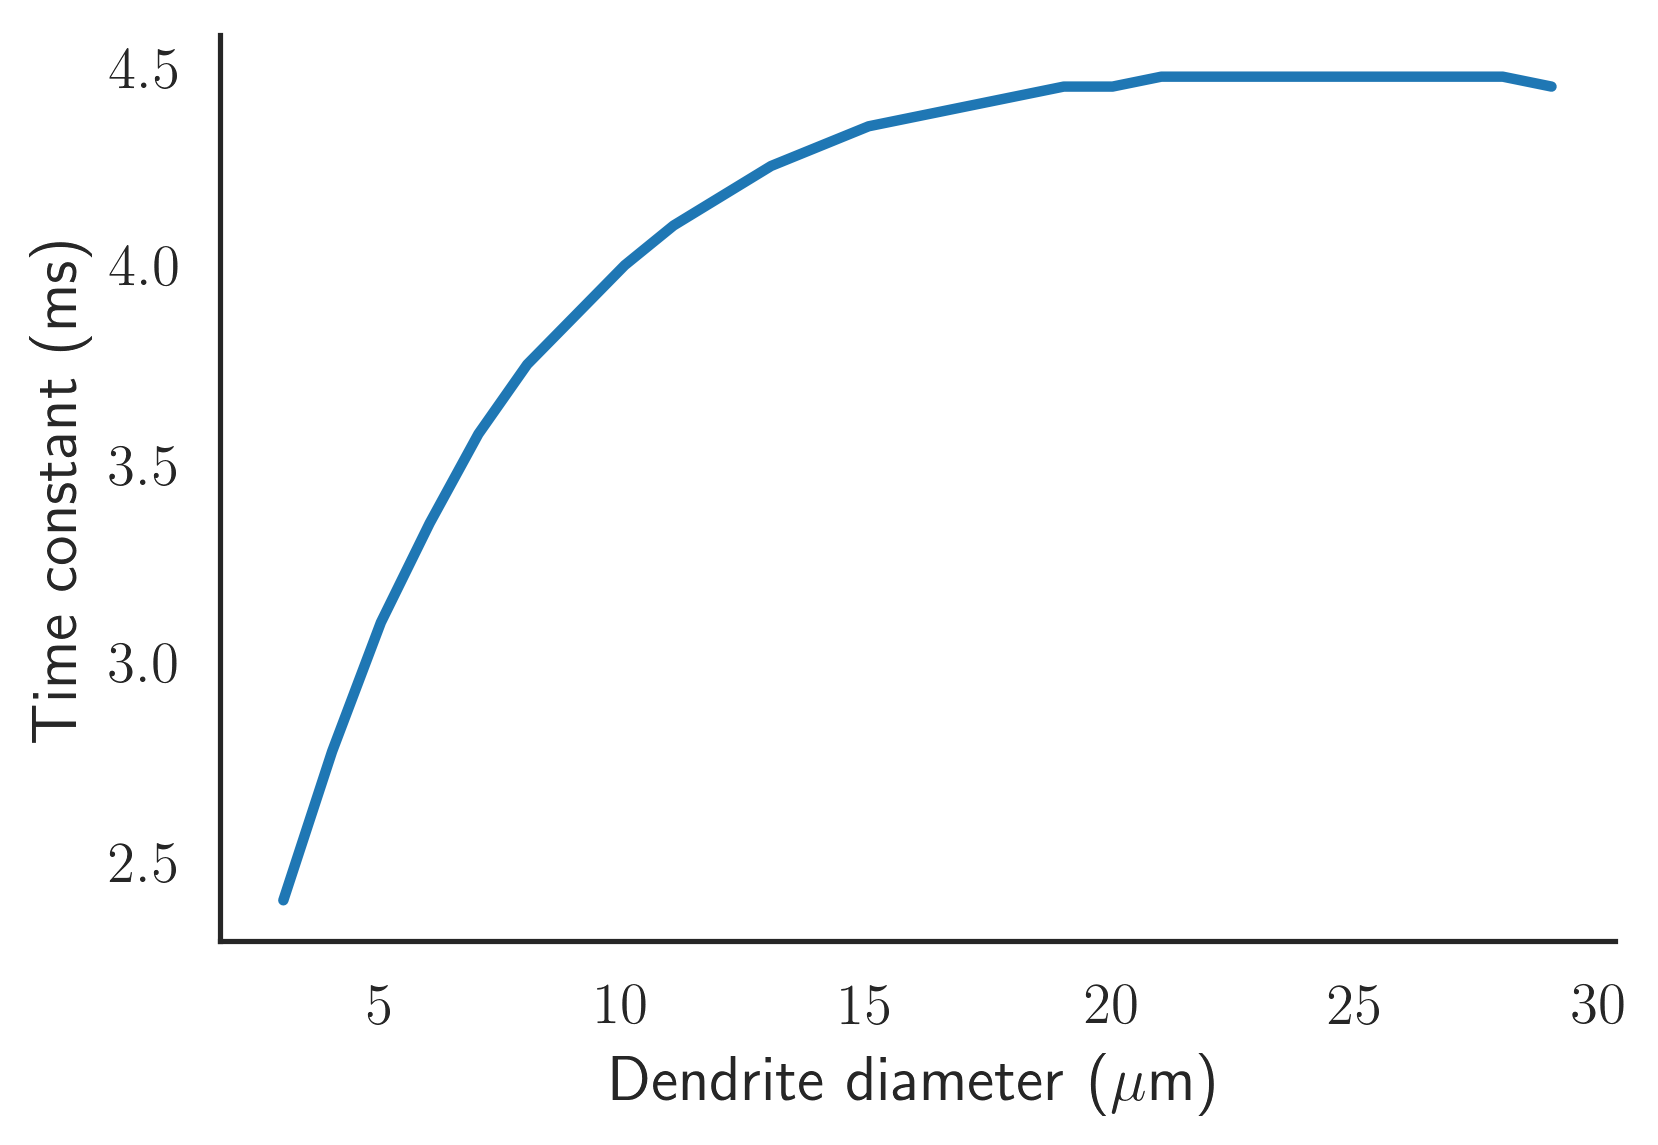

In [36]:
ax = sns.lineplot(dendrite_diam_list, TauM_list)
ax.set(xlabel='Dendrite diameter ($\mu$m)', ylabel='Time constant (ms)')

In [ ]:
from neuron import h, gui
soma = h.Section(name='soma')
axon = h.Section(name='axon')
dend = [h.Section(name='dend[%d]' % i) for i in range(3)]
for sec in dend:
    sec.connect(soma(1), 0)

h.topology()
s = h.Shape()

# Active properties

## Add HH channels 

Add HH Na and K voltage-gated channel to the ball model and inject current steps (add one at a time to see the effectof each one, and then combine)

In [8]:
from neuron import h, gui
def make_hh_cell(cellName = 'cell', gNa = 0.12, gK = 0.036, gL = 0.0003, eL = -54.3, printProperties = False): 
    """
    makes cell with specified channel conductances
    INPUT 
    gNa | Sodium channel conductance (S / cm2)
    gK  | Potassium channel conductance 
    gL  | Leak conductance 
    eL  | Reversal potential (mV)
    
    Note that default values set in this function are the same as in cell.insert('hh')
    Other implicitly defined properties: 
    ena = 50 
    ek = -77
    cm = 1
    diam = 500, L = 100, Ra = 35.4
    """
    cell = h.Section(name = cellName)
    cell.insert('hh')
    cell.gnabar_hh = gNa
    cell.gkbar_hh = gK 
    cell.gl_hh = gL
    cell.el_hh = eL
    
    if printProperties is True: 
        h.topology()
        h.psection()
    
    return cell

### Only adding Na voltage-gated channel

|-|       cell(0-1)
|-|       hh_cell(0-1)
|-|       soma_hh(0-1)

cell { nseg=1  L=12.6157  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=12.6157}
	insert capacitance { cm=1}
	insert hh { gnabar_hh=0 gkbar_hh=3 gl_hh=0.0003 el_hh=50}
	insert na_ion { ena=50}
	insert k_ion { ek=-77}
	insert pas { g_pas=0.001 e_pas=-70}
}
Vector[42]


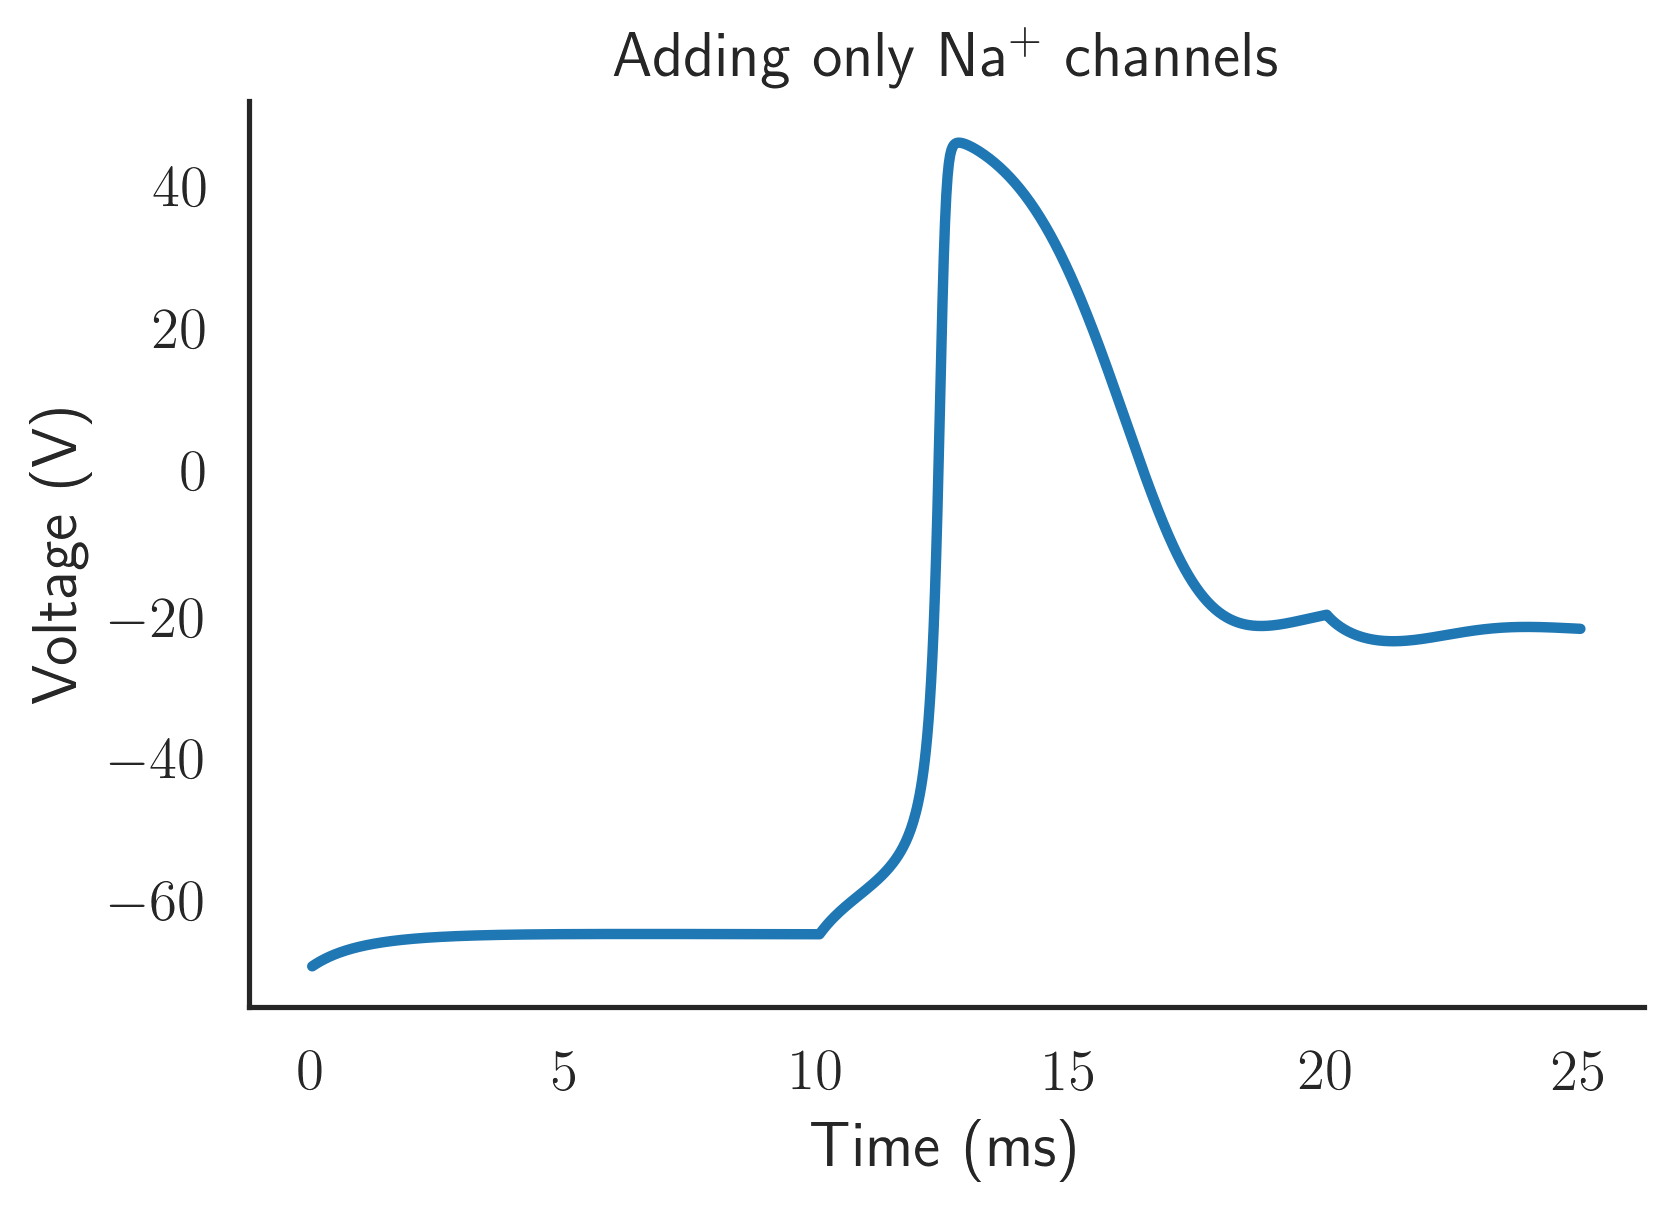

In [23]:
from neuron import h, gui
import seaborn as sns 
    
soma_hh = h.Section(name='soma_hh')
soma_hh.insert('hh')
soma_hh.gnabar_hh = 0.12 # peak sodium conductance
soma_hh.gkbar_hh = 0 # remove sodium conductance 
soma_hh.el_hh = -54.3 # leaak conductance 

# view cell structure 
h.topology()

# view cell properties 
h.psection()

# inject current

voltage_np, time_np = inject_current(cell = soma_hh, somaLength = 12.6157,
somaDiam = 12.6157, stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25)

# plot 
aesthetics()
ax = sns.lineplot(time_np, voltage_np)
ax.set_title('Adding only Na$^+$ channels')
ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
sns.despine()

print(time_np)


### Only adding K voltage-gated channel

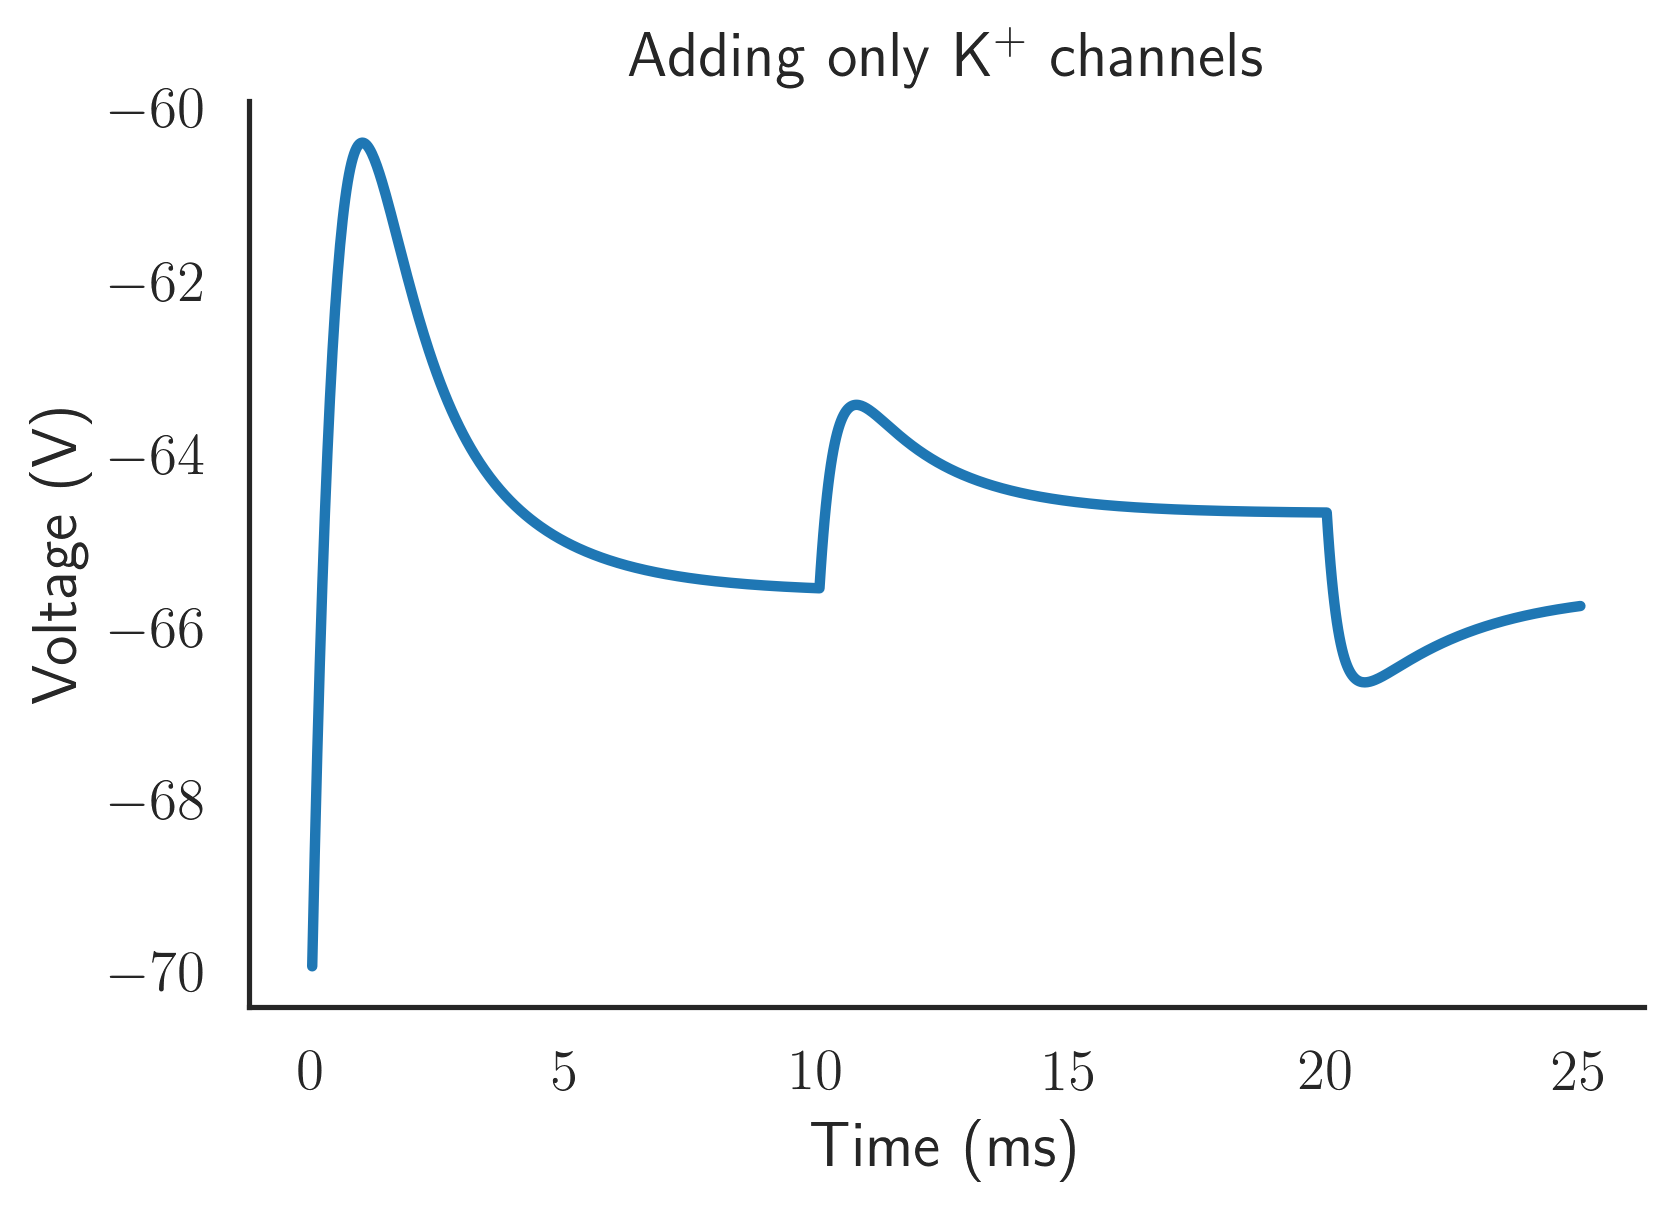

In [25]:
k_only_cell = make_hh_cell(cellName = 'cell', gNa = 0, gK = 0.3, gL = 50)

voltage_np, time_np = inject_current(cell = k_only_cell, somaLength = 12.6157,
somaDiam = 12.6157, stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25)

aesthetics()
ax = sns.lineplot(time_np, voltage_np)
ax.set_title('Adding only K$^+$ channels')
ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
sns.despine()

### Adding both Na and K voltage-gated channel

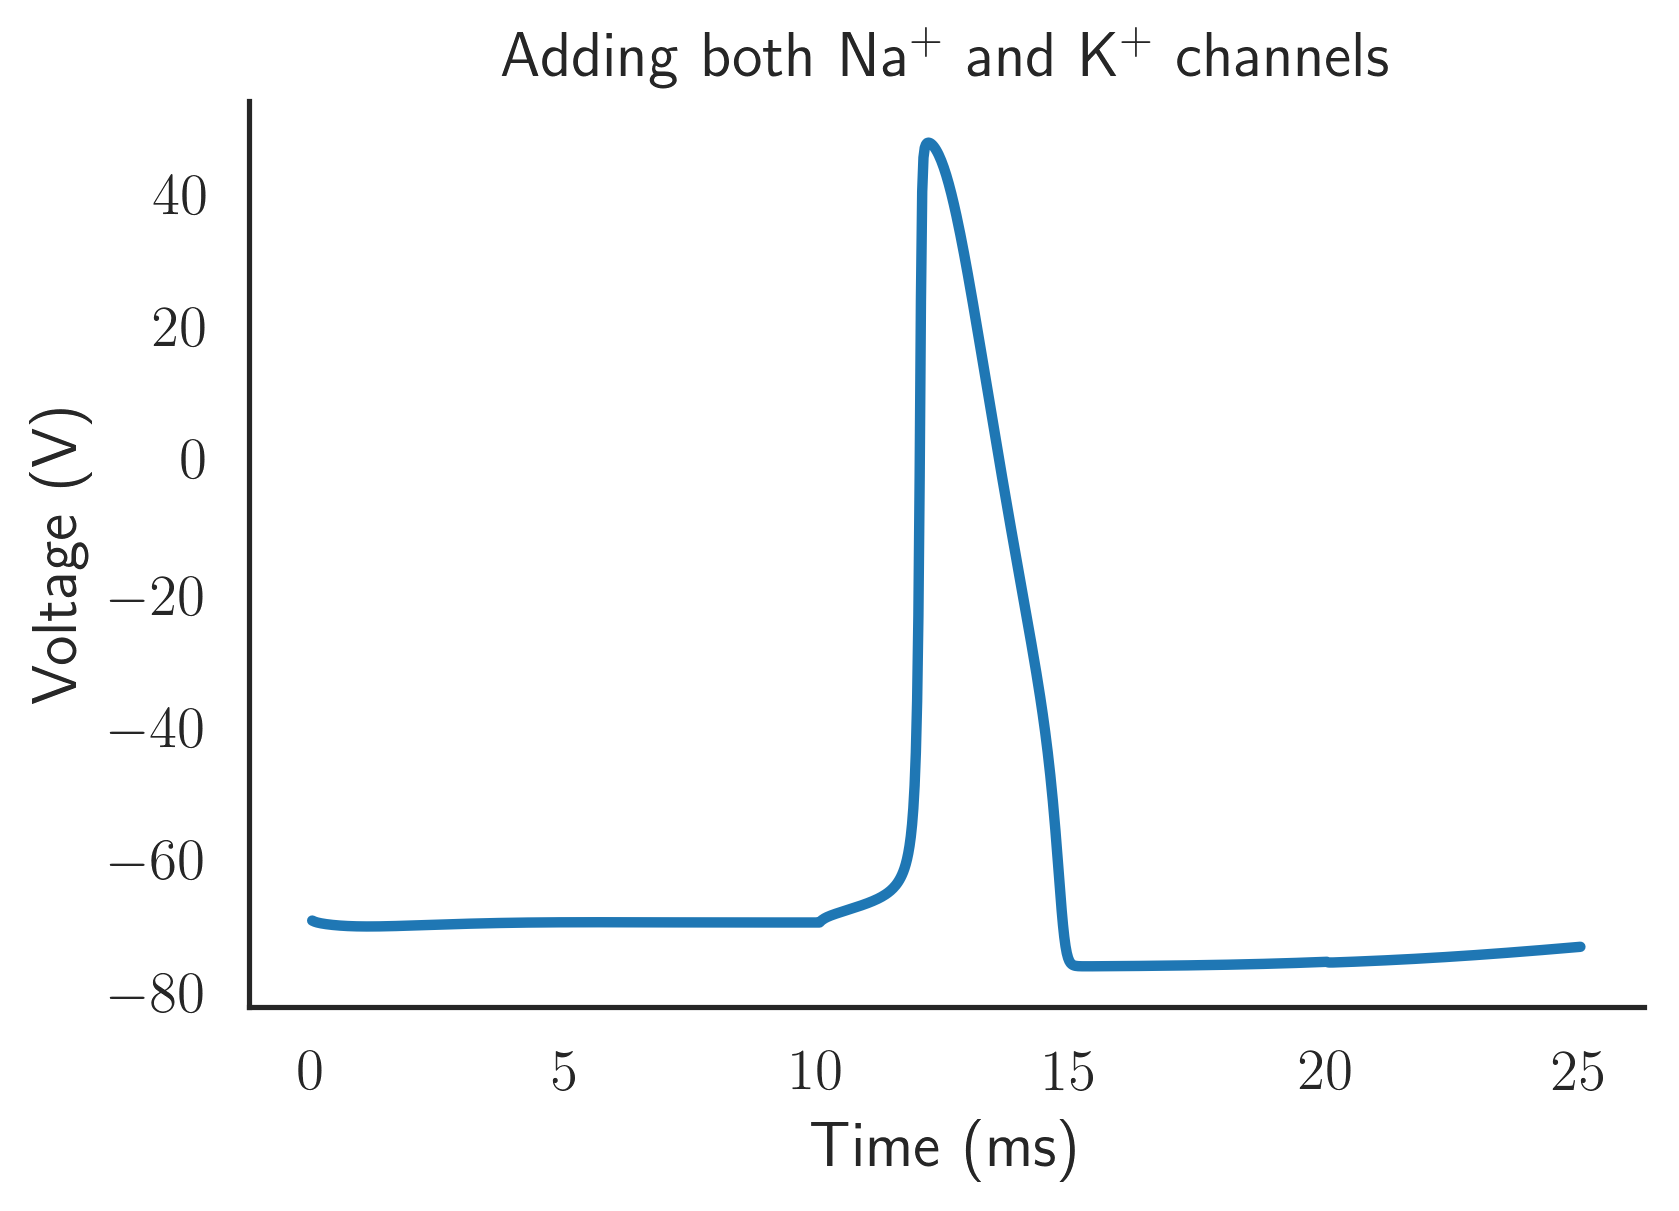

In [22]:
hh_cell = make_hh_cell(cellName = 'hh_cell', gNa = 10, gK = 2.5, gL = 50)

voltage_np, time_np = inject_current(cell = hh_cell, somaLength = 12.6157,
somaDiam = 12.6157, stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25)

aesthetics()
ax = sns.lineplot(time_np, voltage_np)
ax.set_title('Adding both Na$^+$ and K$^+$ channels')
ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
sns.despine()

## Measure gNa and gKv as a function of current injection at the soma

and plot activation curves (from resting $V_m$)

Measuring conductnace: 

$$
R = \frac{V}{I}
$$

$$
g = \frac{I}{V}
$$


[0.042254471631587395, 0.042254471631587395, 0.042254471631587395, 0.042254471631587395, 0.042254471631587395, 0.042254471631587395, 0.042254471631587395, 0.042254471631587395, 0.042254471631587395, 0.042254471631587395]
[0 1 2 3 4 5 6 7 8 9]


[Text(0, 0.5, 'Max voltage (mV)'), Text(0.5, 0, 'Current (nA)')]

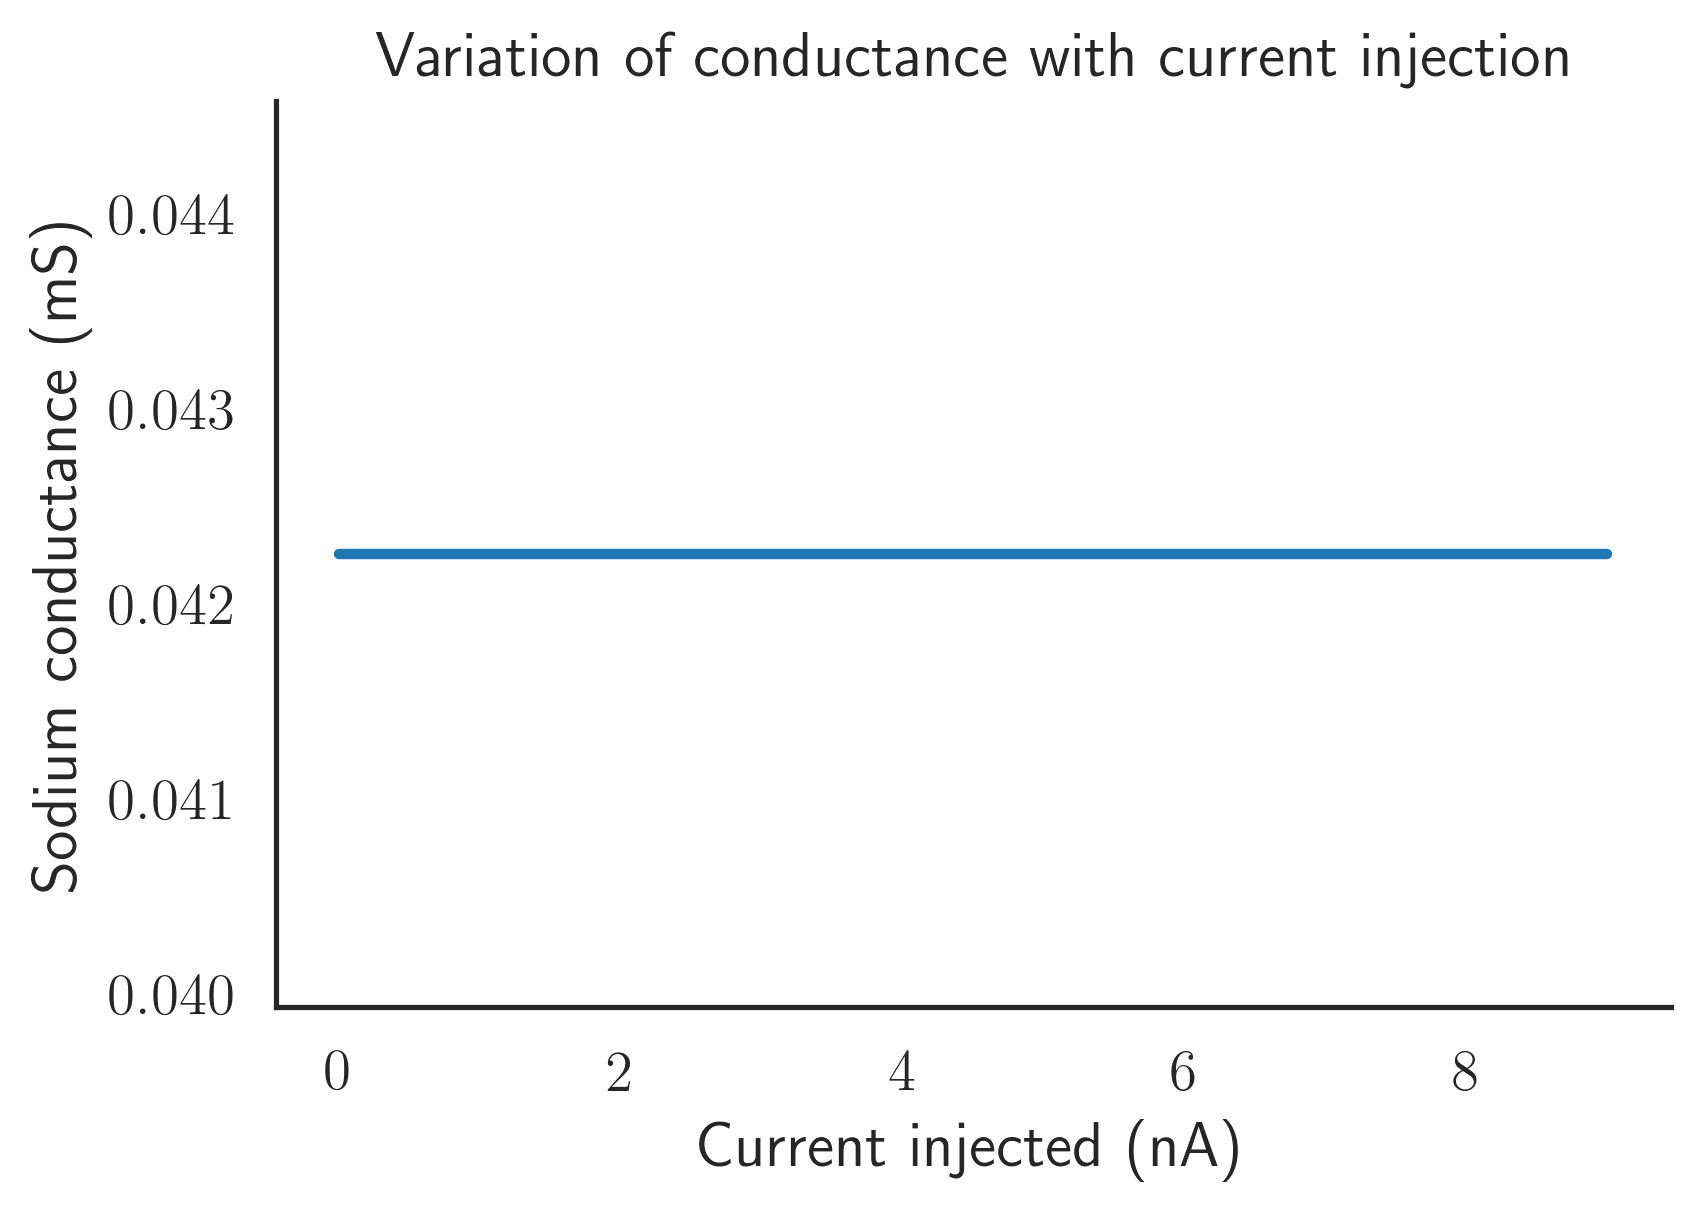

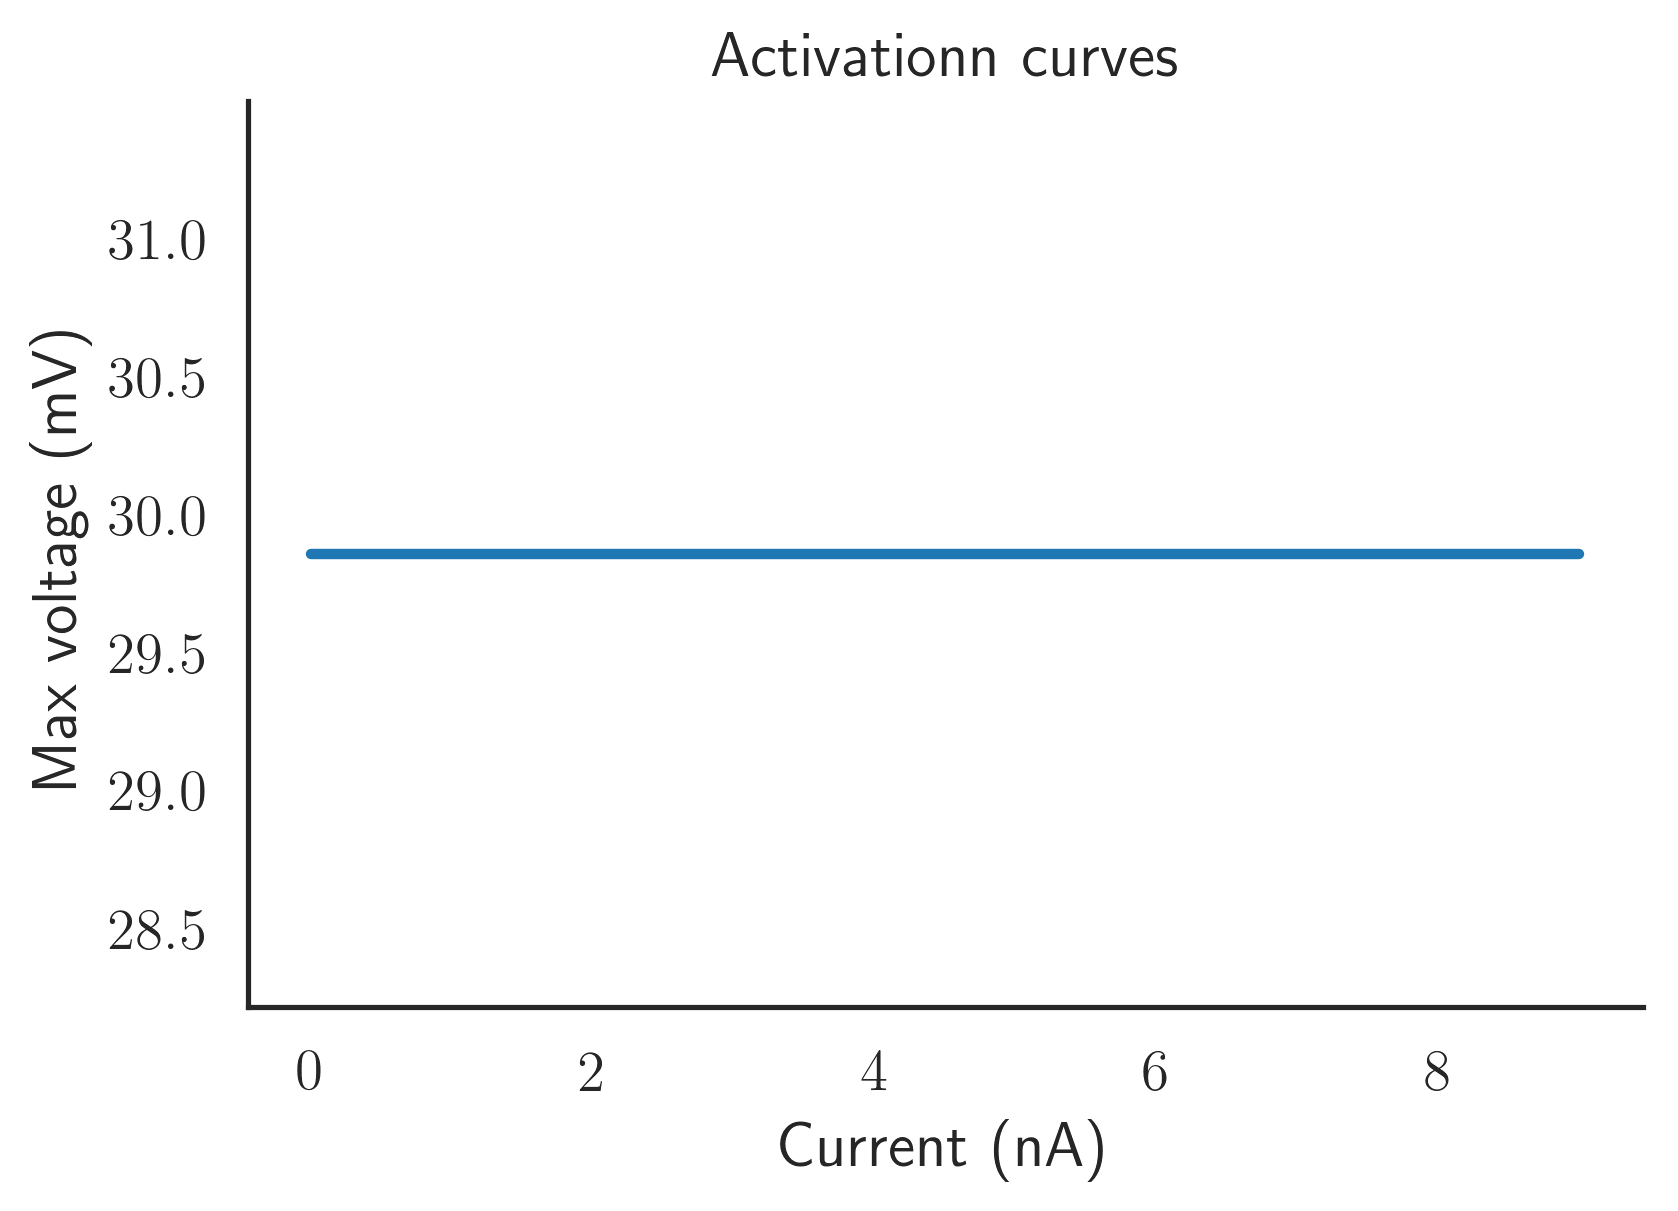

In [105]:
from neuron import h, gui 
import seaborn as sns
import matplotlib.pyplot as plt

currMin = 0
currMax = 10
currStep = 1
curr_amp_list = np.arange(currMin, currMax, currStep)
gNa_measured = list()
gKv_measured = list()
max_voltage_list = list()

def record_conductance(cell, somaLength = 12.6157, somaDiam = 12.6157, 
                   stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25, vInit = -70,
                       v_clamp_amp1 = 10, v_clamp_amp2 = 30, v_clamp_amp3 = 10,
                       v_clamp_dur1 = 10, v_clamp_dur2 = 20, v_clamp_dur3 = 20,
                  printProperties = False, 
                      injectCurrent = False):
    
    # cell.insert('pas')
    cell.L = somaLength 
    cell.diam = somaDiam
    
    if printProperties is True:
        print('Cell properties')
        h.psection()
        
    # insert HH properties 
    cell.insert('hh')
    # set Vm
    # cell.el_hh = vInit
    
    # set resting potential 
    # for seg in cell:
    #     seg.hh.el = vInit
    
    
    if printProperties is True:
        h.psection(cell)
    
    # add point process: current injection 
    if injectCurrent is True:
        stim = h.IClamp(cell(0.5))
        stim.delay = stimDelay
        stim.dur = stimDur # ms
        stim.amp = stimAmp # nA
    
    v_clamp = h.SEClamp(cell(0.5))
    v_clamp.amp1 = v_clamp_amp1
    v_clamp.amp2 = v_clamp_amp2 
    # v_clamp.amp3 = 
    
    # series resistance
    v_clamp.rs = 0.01
    
    v_clamp.dur1 = v_clamp_dur1 
    v_clamp.dur2 = v_clamp_dur2
    v_clamp.dur3 = v_clamp_dur3 
    
    
    # measure voltage 
    voltage = h.Vector()
    voltage.record(cell(0.5)._ref_v)
    
    gNa = h.Vector()
    gNa.record(cell(0.5)._ref_gna_hh)
    
    gKv = h.Vector()
    gKv.record(cell(0.5)._ref_gk_hh)
    
    # measure time
    time = h.Vector()
    time.record(h._ref_t)
    
    # h.v_init = vInit # initial voltage
    
    # h.finitialize(vInit)
    
    h.load_file('stdrun.hoc')
    h.tstop = total_time
    h.run() # ms
    
    
    return gNa, gKv, voltage, time

aesthetics()

for curr_amp in curr_amp_list:
    conductance_cell = h.Section(name='conductance_cell')
    gNa, gKv, voltage, time = record_conductance(conductance_cell, stimAmp = curr_amp)
    gNa_measured.append(max(gNa))
    gKv_measured.append(max(gKv))
    max_voltage_list.append(max(voltage))
    # sns.lineplot(time, voltage)
    # plot activation curves 
    # plt.subplot(1, 2, 1)
    # active_curve = sns.lineplot(time, voltage)
    # current
    # active_curve.set(xlabel = 'Time (ms)', ylabel = 'Voltage (mV)')
    # active_curve.set_title('Activation curves')
    # TODO add label 
    
# active_curve.legend()

# plt.subplot(1, 2, 2)
plt.figure()
ax = sns.lineplot(curr_amp_list, gNa_measured)
ax.set_title('Variation of conductance with current injection')
ax.set(xlabel='Current injected (nA)', ylabel='Sodium conductance (mS)')
sns.despine()

print(gNa_measured)
print(curr_amp_list)

# plot IV curve
plt.figure()
IV_curve = sns.lineplot(curr_amp_list, max_voltage_list)
IV_curve.set_title('Activationn curves')
IV_curve.set(xlabel = 'Current (nA)', ylabel = 'Max voltage (mV)')



## Measure gNa and gKv to a large current step from increasing $V_m$ and plot inactivation curves

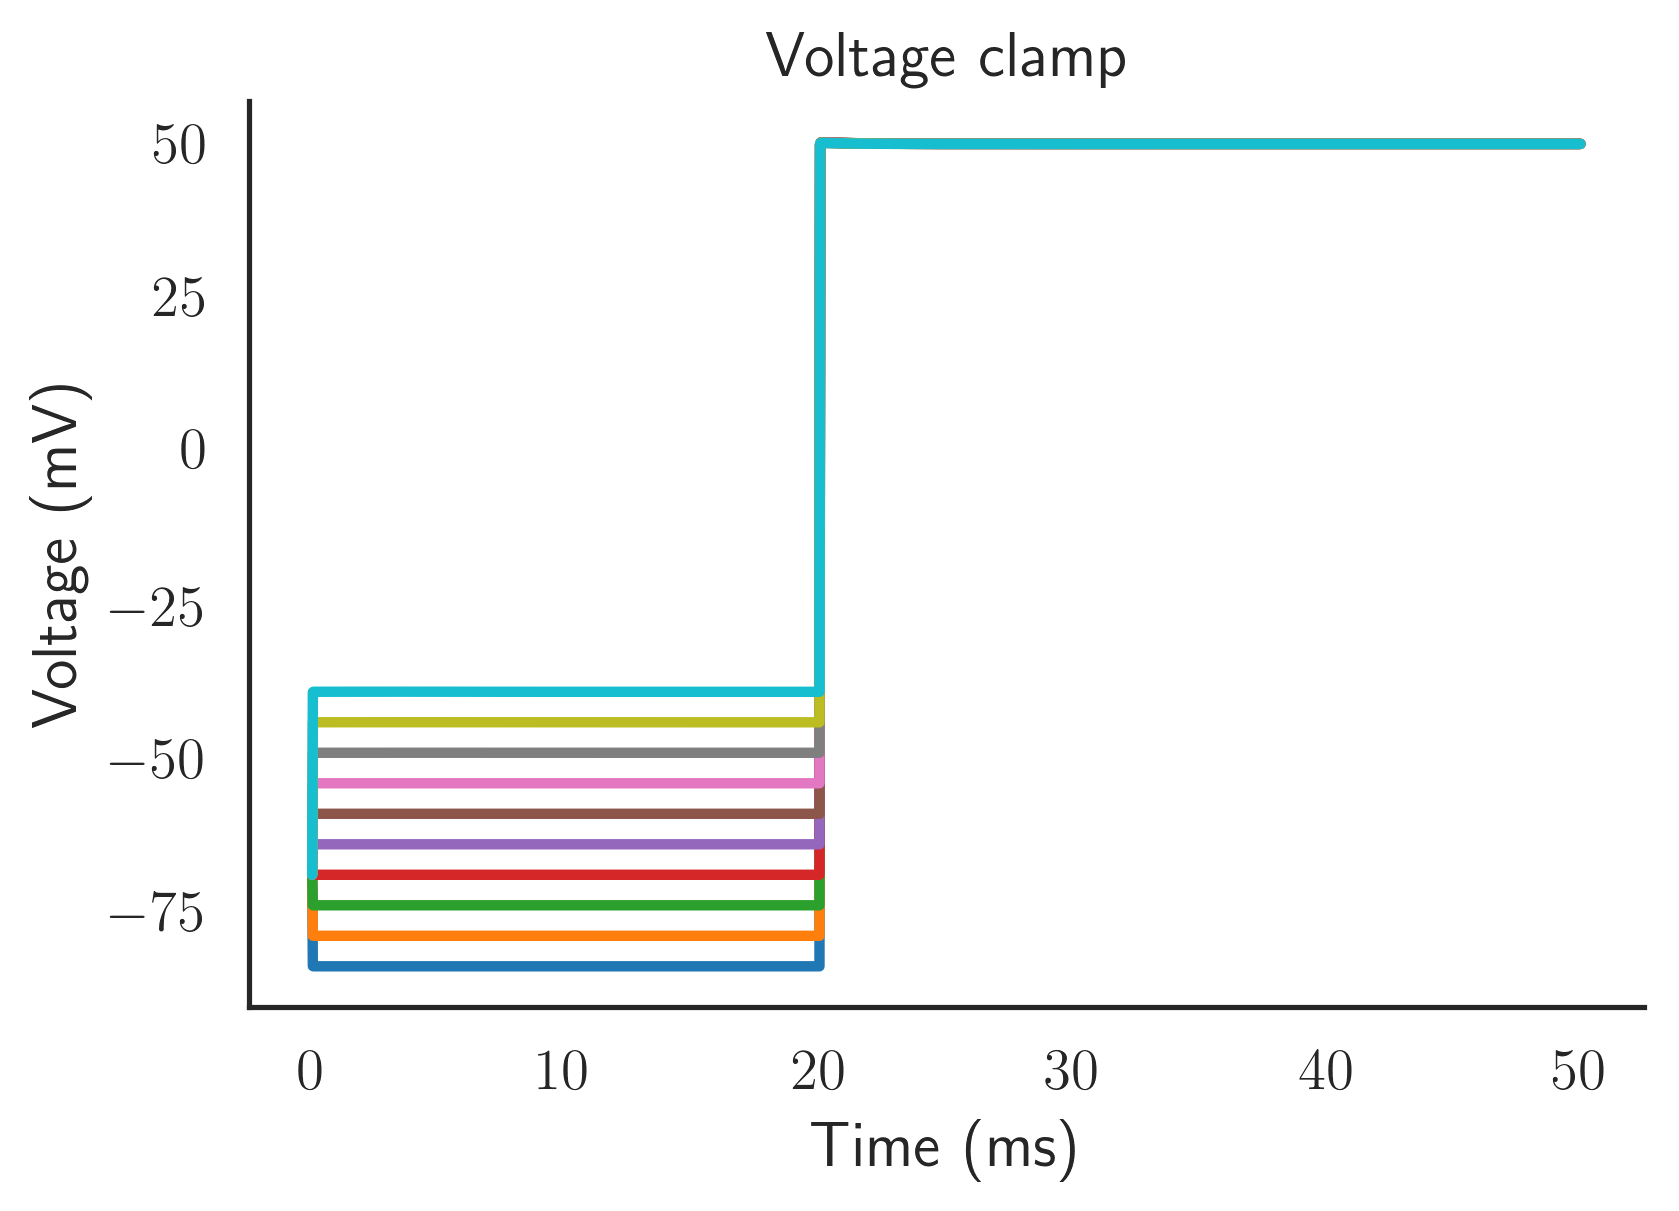

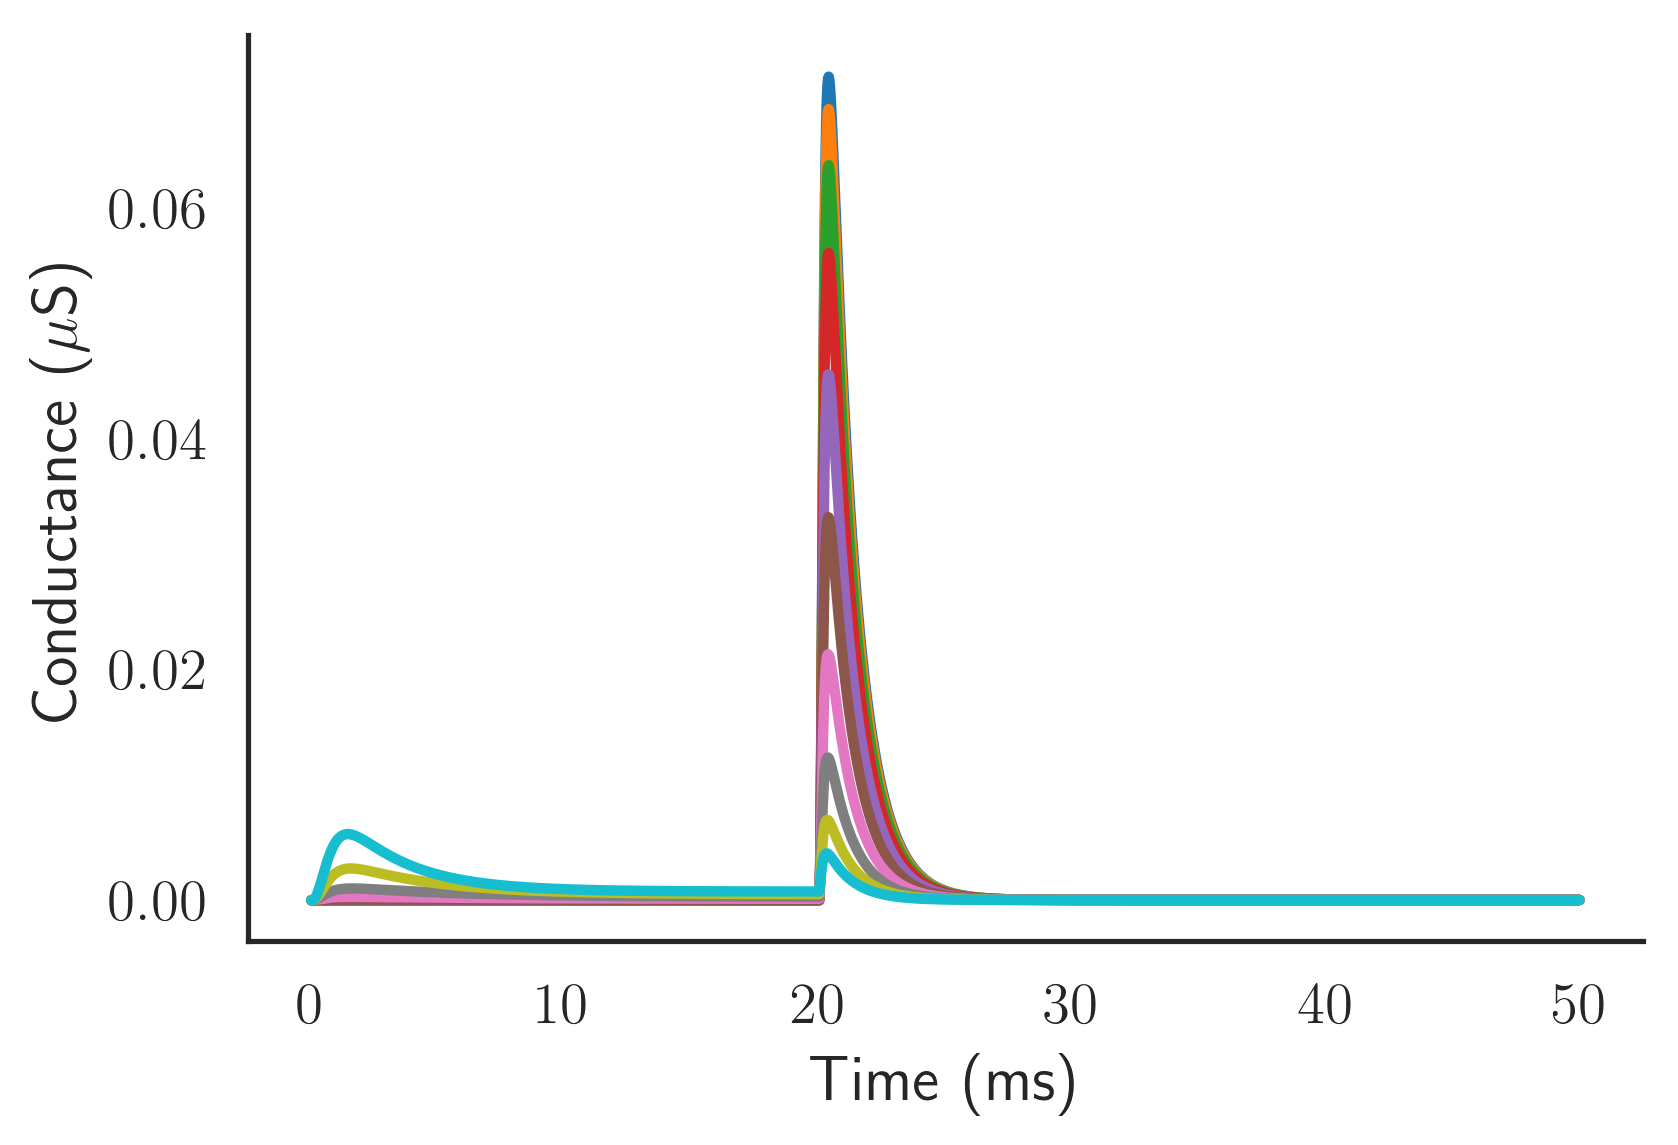

[Text(0, 0.5, 'Peak conductance ($\\mu$S)'),
 Text(0.5, 0, 'Potential differrence (V)')]

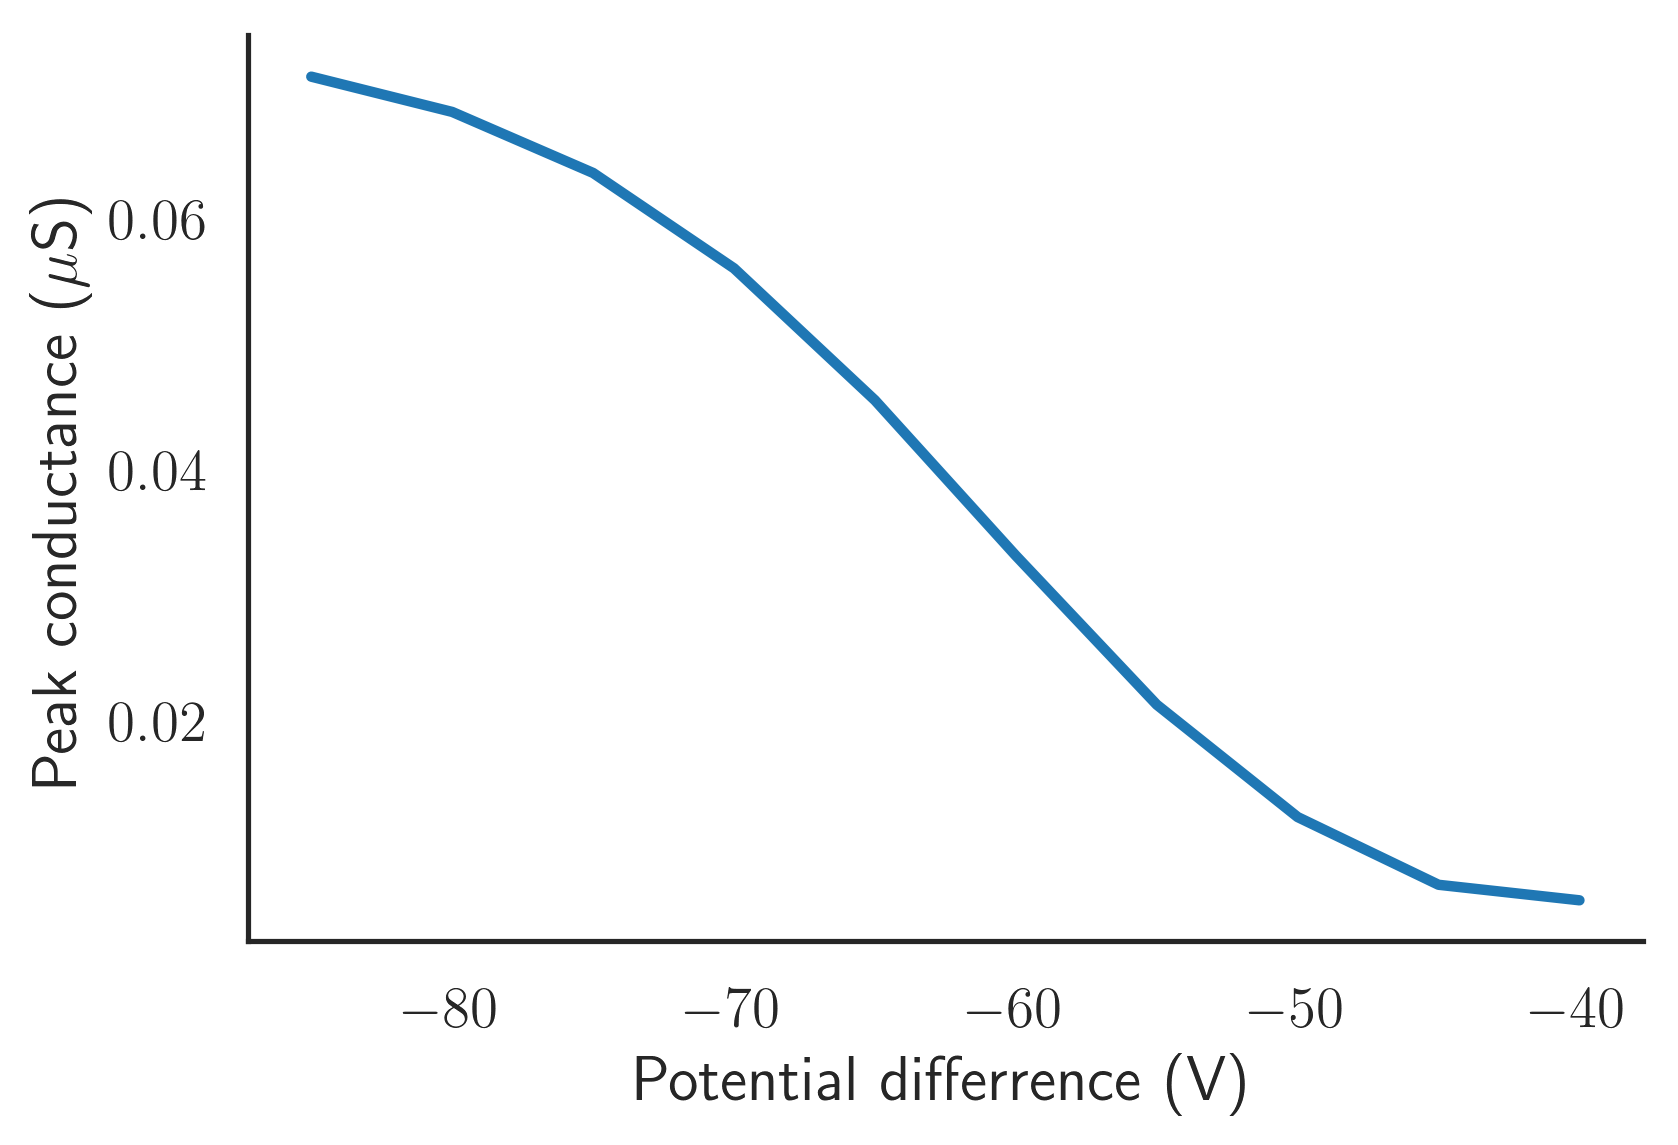

In [132]:
# Vm_list = [-70, -60, -50, -40, -30]
# v_clamp_amp1_list = [-100, -90, -80, -70, -60, 20]
# v_clamp_amp1_list = np.arange(-150, 50, 5)
v_clamp_amp1_list = np.arange(-85, -35, 5)
v_clamp_amp2 = 50

# v_clamp_amp1 = -70
# v_clamp_amp2 = np.

v_clamp_dur1 = 20
v_clamp_dur2 = 30

curr_amp = 0.5

gNa_measured = list()
gKv_measured = list()

aesthetics()

for v_clamp_amp1 in v_clamp_amp1_list:
    conductance_cell = h.Section(name='conductance_cell')
    gNa, gKv, voltage, time = record_conductance(conductance_cell, stimAmp = curr_amp, vInit = Vm,
                                                 stimDelay = 10, total_time = 50,
                                                 v_clamp_amp1 = v_clamp_amp1, v_clamp_amp2 = v_clamp_amp2,
                                                 v_clamp_dur1 = v_clamp_dur1, v_clamp_dur2 = v_clamp_dur2,
                                                printProperties = False)
    gNa_measured.append(max(gNa))
    gKv_measured.append(max(gKv))
    # sns.lineplot(time, voltage)
    # plot activation curves 
    # plt.subplot(1, 2, 1)
    # inactive_curve = sns.lineplot(time, voltage)
    plt.figure(1)
    # plt.subplot(1, 2, 1)
    inactive_curve = plt.plot(time, voltage)
    plt.title('Voltage clamp')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    # inactive_curve.set(xlabel = 'Time (ms)', ylabel = 'Voltage (mV)')
    # inactive_curve.set_title('Voltage clamp')
    
    # conductance over time 
    plt.figure(2)
    # plt.subplot(1, 2, 2)
    # conductance_time = sns.lineplot(time, gNa)
    conductance_time = plt.plot(time, gNa)
    plt.xlabel('Time (ms)')
    plt.ylabel('Conductance ($\mu$S)')
    # conductance_time.set(xlabel = 'Time (ms)', ylabel = 'Conductance ($\mu$S)')

plt.show()
# plt.show(inactive_curve)
# plt.show(conductance_time)

    
plt.figure()
ax = sns.lineplot(v_clamp_amp1_list, gNa_measured)
ax.set(xlabel = 'Potential differrence (V)', ylabel = 'Peak conductance ($\mu$S)')


[Text(0, 0.5, 'Peak conductance ()'),
 Text(0.5, 0, 'Potential differrence (V)')]

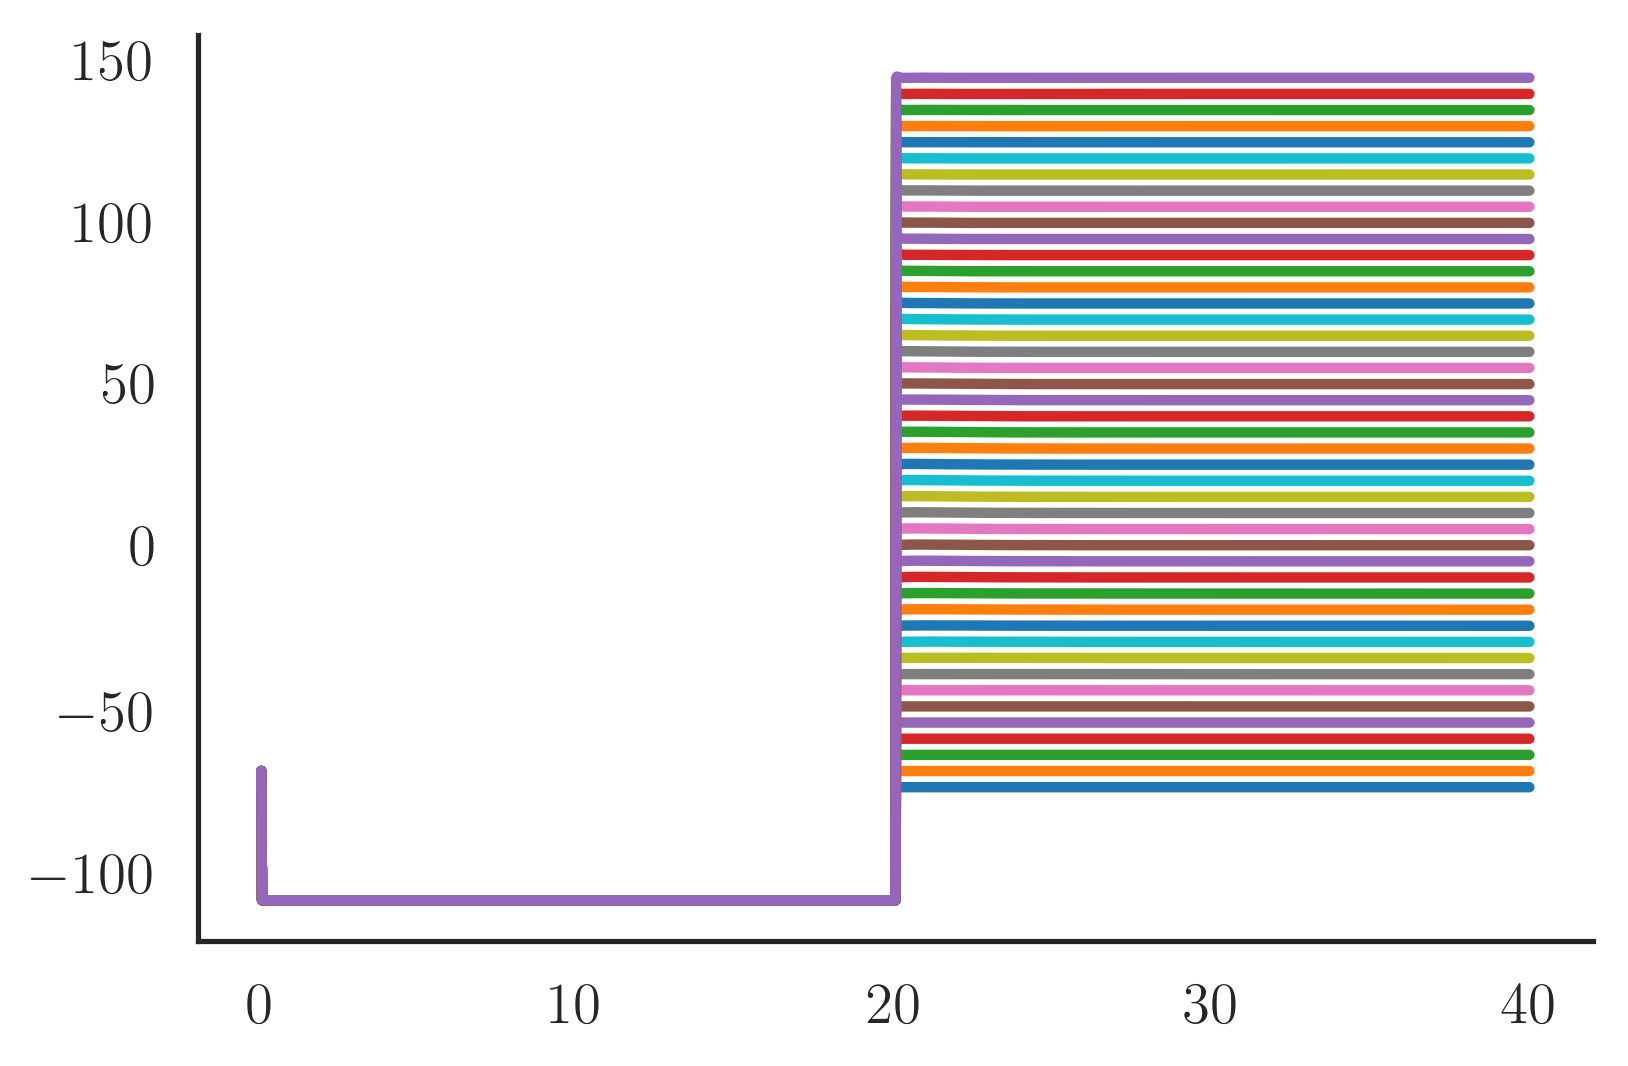

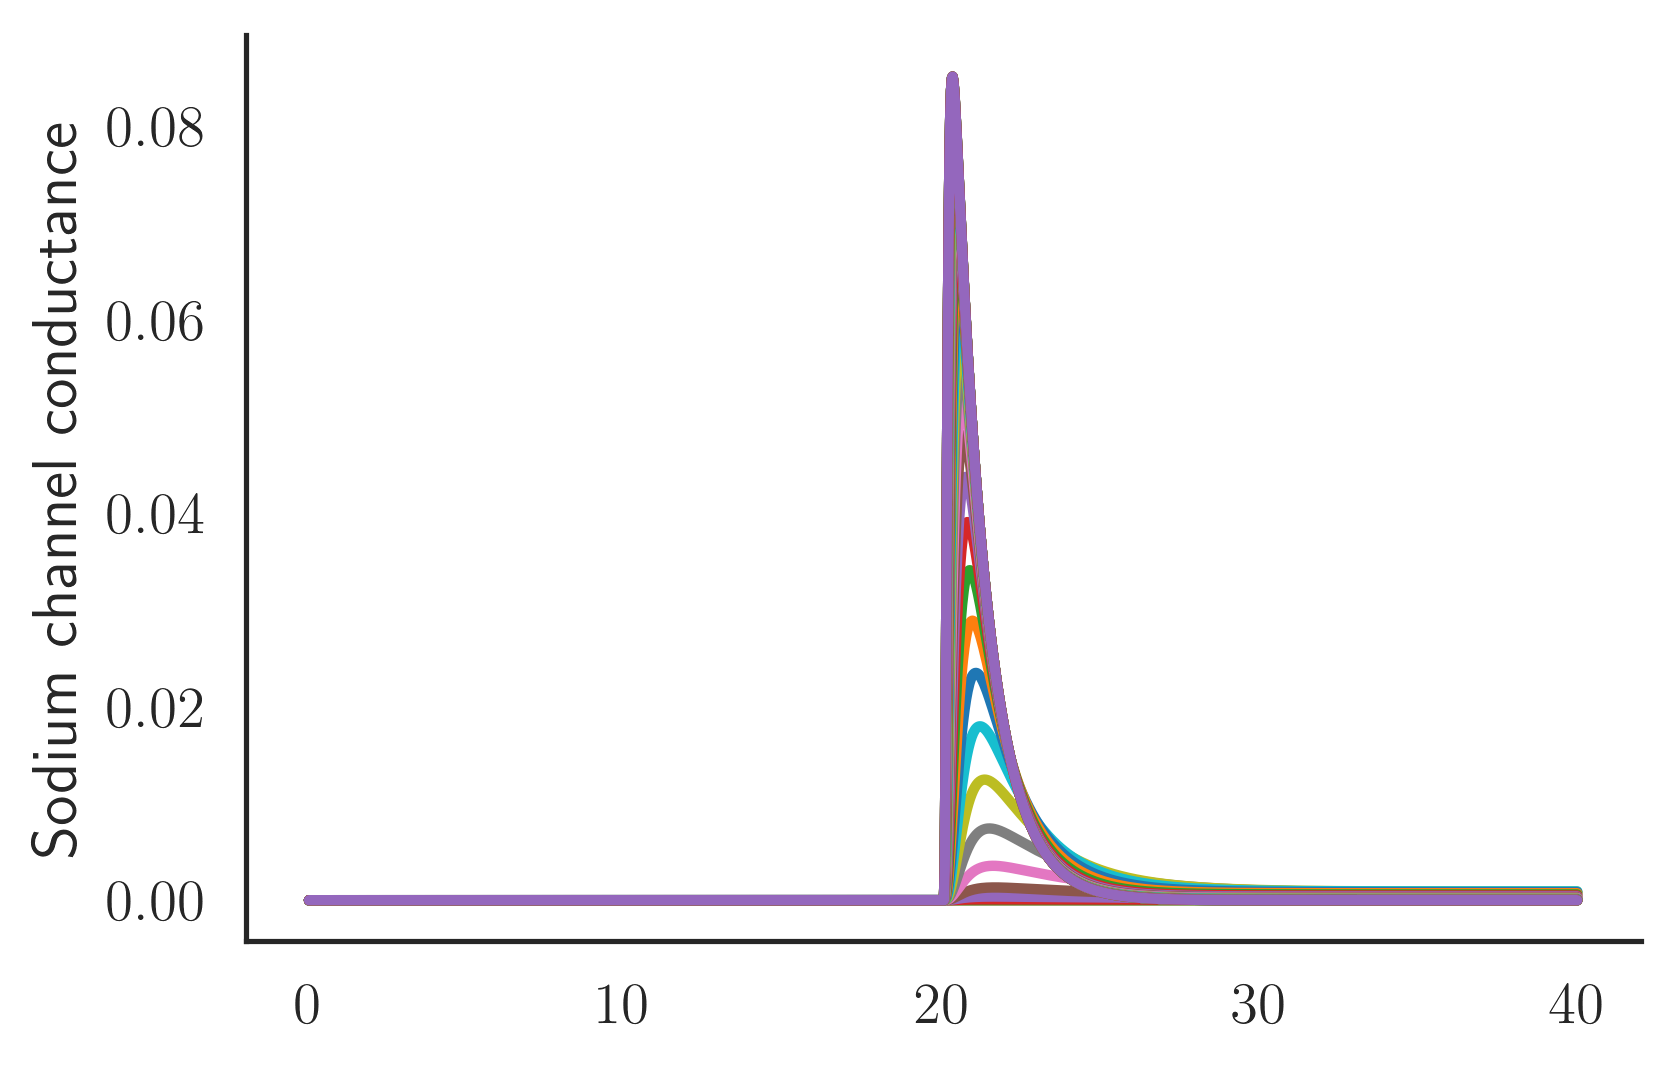

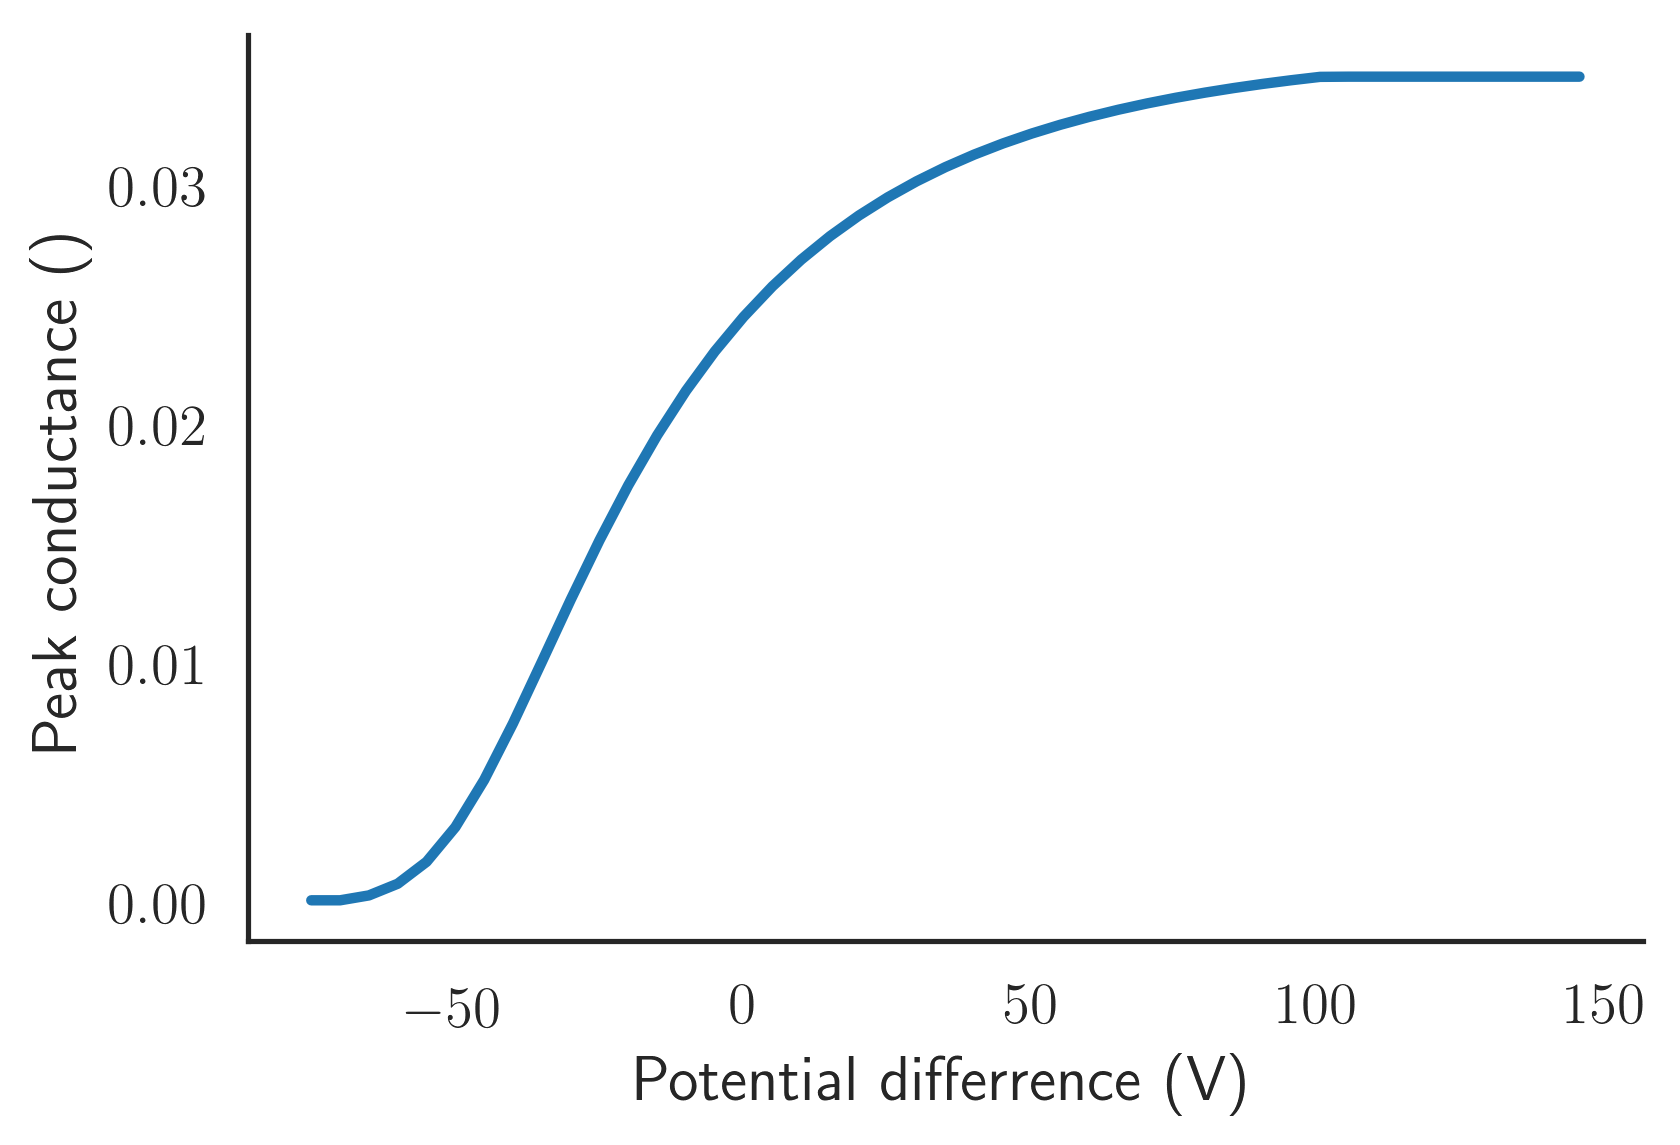

In [133]:
# Vm_list = [-70, -60, -50, -40, -30]
# v_clamp_amp1_list = [-100, -90, -80, -70, -60, 20]
# v_clamp_amp1_list = np.arange(-100, -60, 2)
# v_clamp_amp2 = 50

v_clamp_amp1 = -110
v_clamp_amp2_list = np.arange(-75, 150, 5)

v_clamp_dur1 = 20
v_clamp_dur2 = 30

curr_amp = 0.5

gNa_measured = list()
gKv_measured = list()

aesthetics()

for v_clamp_amp2 in v_clamp_amp2_list:
    conductance_cell = h.Section(name='conductance_cell')
    gNa, gKv, voltage, time = record_conductance(conductance_cell, stimAmp = curr_amp, vInit = Vm,
                                                 stimDelay = 10, total_time = 40,
                                                 v_clamp_amp1 = v_clamp_amp1, v_clamp_amp2 = v_clamp_amp2,
                                                 v_clamp_dur1 = v_clamp_dur1, v_clamp_dur2 = v_clamp_dur2,
                                                printProperties = False)
    # print(gNa)
    gNa_measured.append(max(gNa))
    gKv_measured.append(max(gKv))
    # sns.lineplot(time, voltage)
    # plot activation curves 
    # plt.subplot(1, 2, 1)
    plt.figure(1)
    # inactive_curve = sns.lineplot(time, voltage)
    plt.plot(time, voltage)
    # inactive_curve.set(xlabel = 'Time (ms)', ylabel = 'Voltage (mV)')
    # inactive_curve.set_title('Voltage clamp')
    
    # conductance over time 
    plt.figure(2)
    plt.plot(time, gNa)
    plt.ylabel('Sodium channel conductance')
    # conductance_time = sns.lineplot(time, gKv)
    # conductance_time.set(xlabel = 'Time (ms)', ylabel = 'Conductance')
    

    
plt.figure()
ax = sns.lineplot(v_clamp_amp2_list, gKv_measured)
ax.set(xlabel = 'Potential differrence (V)', ylabel = 'Peak conductance ($\mu$S)')


We used the voltage clamp mode to bring the cell from a negative potential to different increasingly positive voltages. We recorded the peak conductance during these times, and from this plot the conductance as a function of voltage potential changes. This gives us the activation curve of sodium channels, showing that as the voltage gets more positive the more of the sodium channels are activated. 

## Play with gNa and gK density to make an Action Potential

Not too sure what is meant by *density* or how to specify that (ion channel density???)


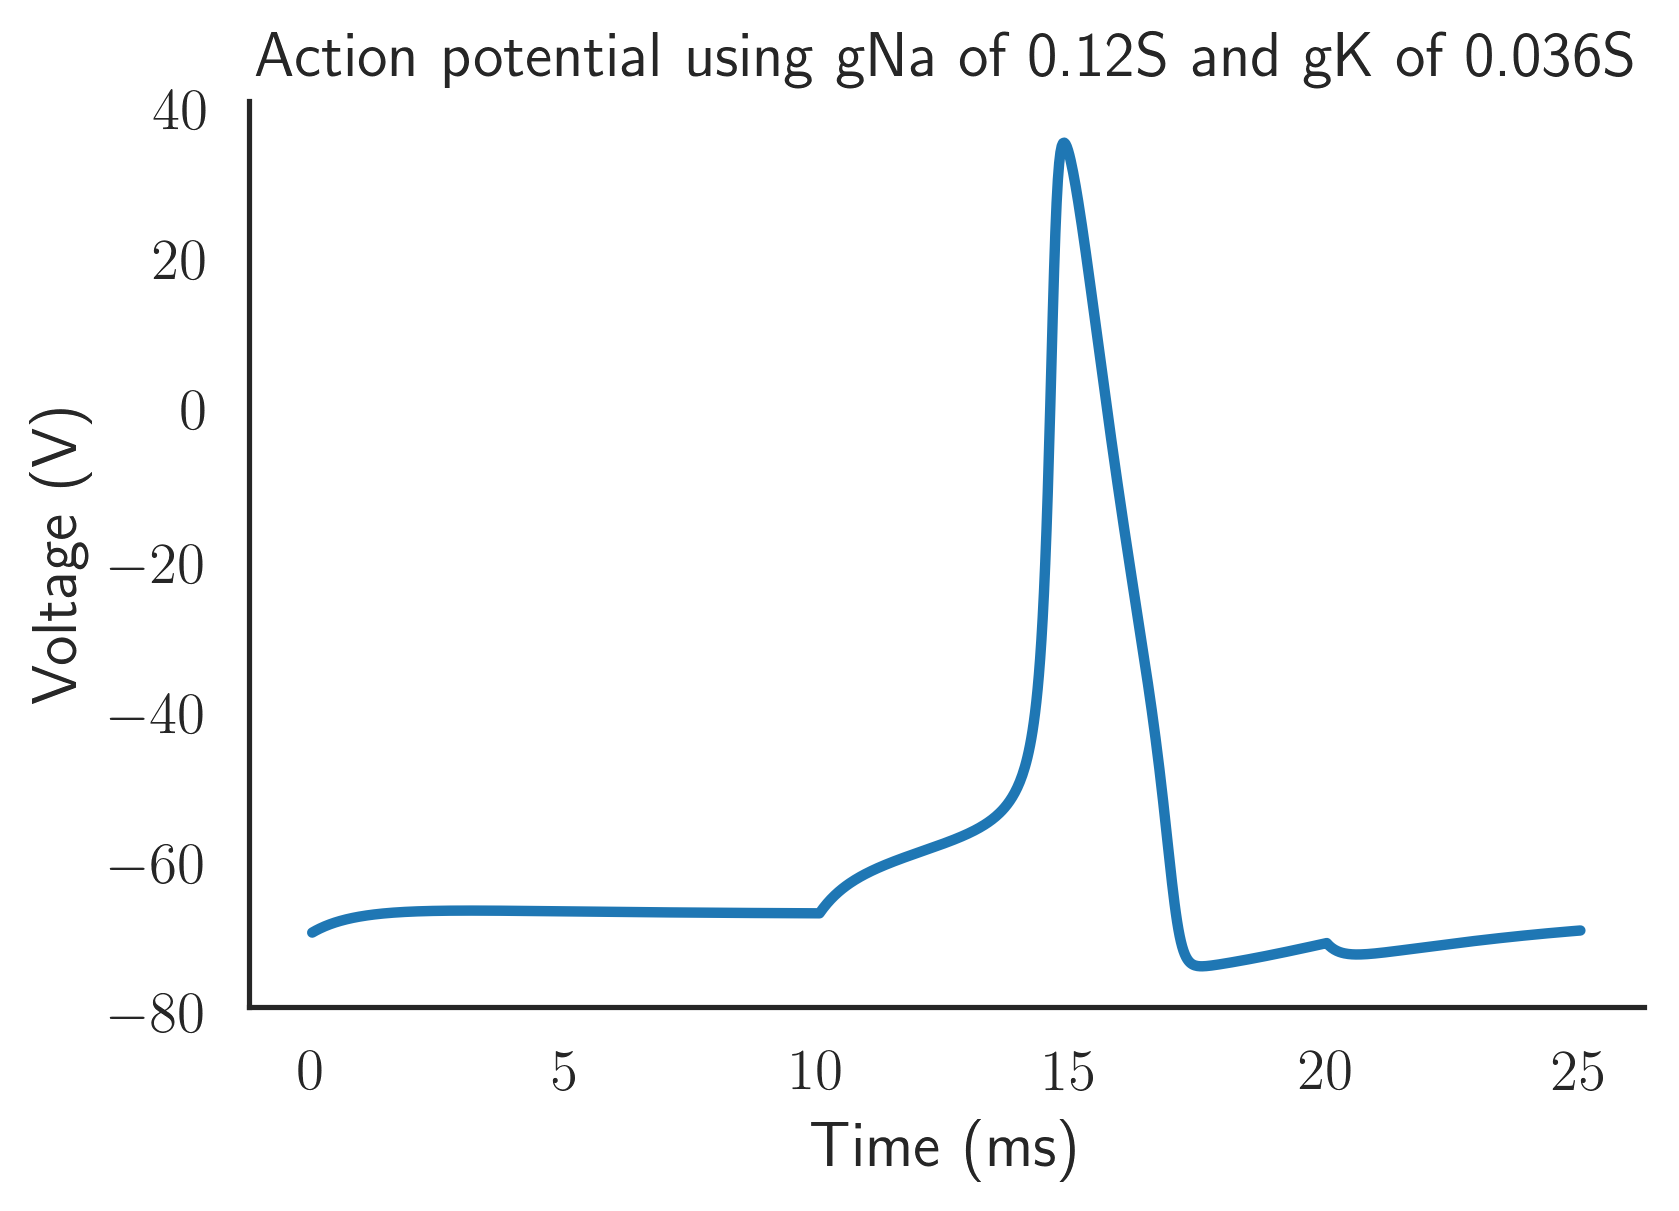

In [14]:
gNa_custom = 0.12 
gK_custom = 0.036
ap_cell = make_hh_cell(cellName = 'ap_cell', gNa = gNa_custom, gK = gK_custom, gL = 0.0003, eL = -54.3, printProperties = False)
voltage_np, time_np = inject_current(cell = ap_cell, somaLength = 12.6157,
somaDiam = 12.6157, stimDur = 10, stimAmp = 0.05, stimDelay = 10, total_time = 25)

aesthetics()
ax = sns.lineplot(time_np, voltage_np)
ax.set_title('Action potential using gNa of %.2fS and gK of %.3fS' % (gNa_custom, gK_custom))
ax.set(xlabel='Time (ms)', ylabel='Voltage (V)')
sns.despine()

## Add an axon and try to make the AP start in the axon

# Synaptic integration

## Add a single alpha excitatory synapse in the soma and then in the dendrite

Progressively far away, and record at the soma. What changes?

Background: 

 - A synapse (for the purpose of this simulation) is a location of transmitter release, which then binds to post-synaptic receptors at the soma to cause change in coductance for one or more ions
  - The conductance change (usually increase) can be described by a mathematical function 
  - An alpha synapse is a synapse in which the conductance change in the post-synapse cell can be described by the *alpha function* 
 - In `NEURON`, the alpha synapse is a point process (ie. it is assumed to be a point source of current along the cell)
  
There seems to be multiple mathematical definition of the alpha function, and `NEURON` implements the alpha function (see ref 3) via:

$$
g(t) = g_\text{max} \alpha t e^{1 - \alpha t}
$$
  
References: 

 - [AlphaSynapse](http://fohs.bgu.ac.il/nia/nia2003/neurolab/help/alphasyn.htm)
 - [Alpha function, Wolfram](http://mathworld.wolfram.com/AlphaFunction.html)
 - [NEURON forum on alpha function](https://www.neuron.yale.edu/phpBB/viewtopic.php?t=2982)
 


In [75]:
%reset -f 
from neuron import h, gui
# setting up functions to make cell and recording
def make_alpha_cell(alphaLocation = 0.5, onset = 20, gmax = 1, printProperties = False):
    """
    Makes a cell with soma, dendrite and alpha synapse 
    INPUT 
    alphaLocation | location to insert the alpha synapse
    onset         | Onset of the synapse (similar to stimDelay) (ms)
    gmax          | maximum conductance (ohms???)
    
    OUTPUT 
    alpha_cell    | NEURON cell object
    """
    alpha_cell = h.Section(name='alpha_cell')
    alpha_cell.insert('pas')
    # add dendrite 
    # dendrite = h.Section(name = 'dendrite')
    # add alpha synapse 
    asyn = h.AlphaSynapse(alpha_cell(alphaLocation))
    asyn.onset = onset 
    asyn.gmax = gmax
    
    if printProperties is True: 
        h.psection(alpha_cell)
    
    return alpha_cell

def measure_V(cell, runTime = 40, recordLocation = 0.5, vInit = -70, printProperties = True):
    """
    Measure change in potential difference (V) over time (t) for a NEURON cell object
    INPUT 
    cell           | the NEURON cell object 
    runTime        | how long to run the measurements for (ms)
    recordLocation | location along the cell to record (0 - 1, two ends of the cell) 
    vInit          | initial voltage, set at -70 to prevent initially drop from -65.5 to -70 resting
    
    OUTPUT 
    voltage 
    time 
    Note that they are NEURON objects, and will need to be used via voltage.asnumpy() and time.asnumpy()
    """
    if printProperties is True: 
        h.psection(cell)
        
    
    voltage = h.Vector()             # Membrane potential vector
    time = h.Vector()             # Time stamp vector
    voltage.record(cell(recordLocation)._ref_v)
    time.record(h._ref_t)
    
    h.v_init = vInit # initial voltage
    
    # h.load_file('stdrun.hoc') #  (only necessary of gui is not imported)
    
    h.tstop = runTime
    h.run()
    
    return voltage, time


alpha_cell { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
	insert AlphaSynapse { onset=20 tau=0.1 gmax=1 e=0}
}


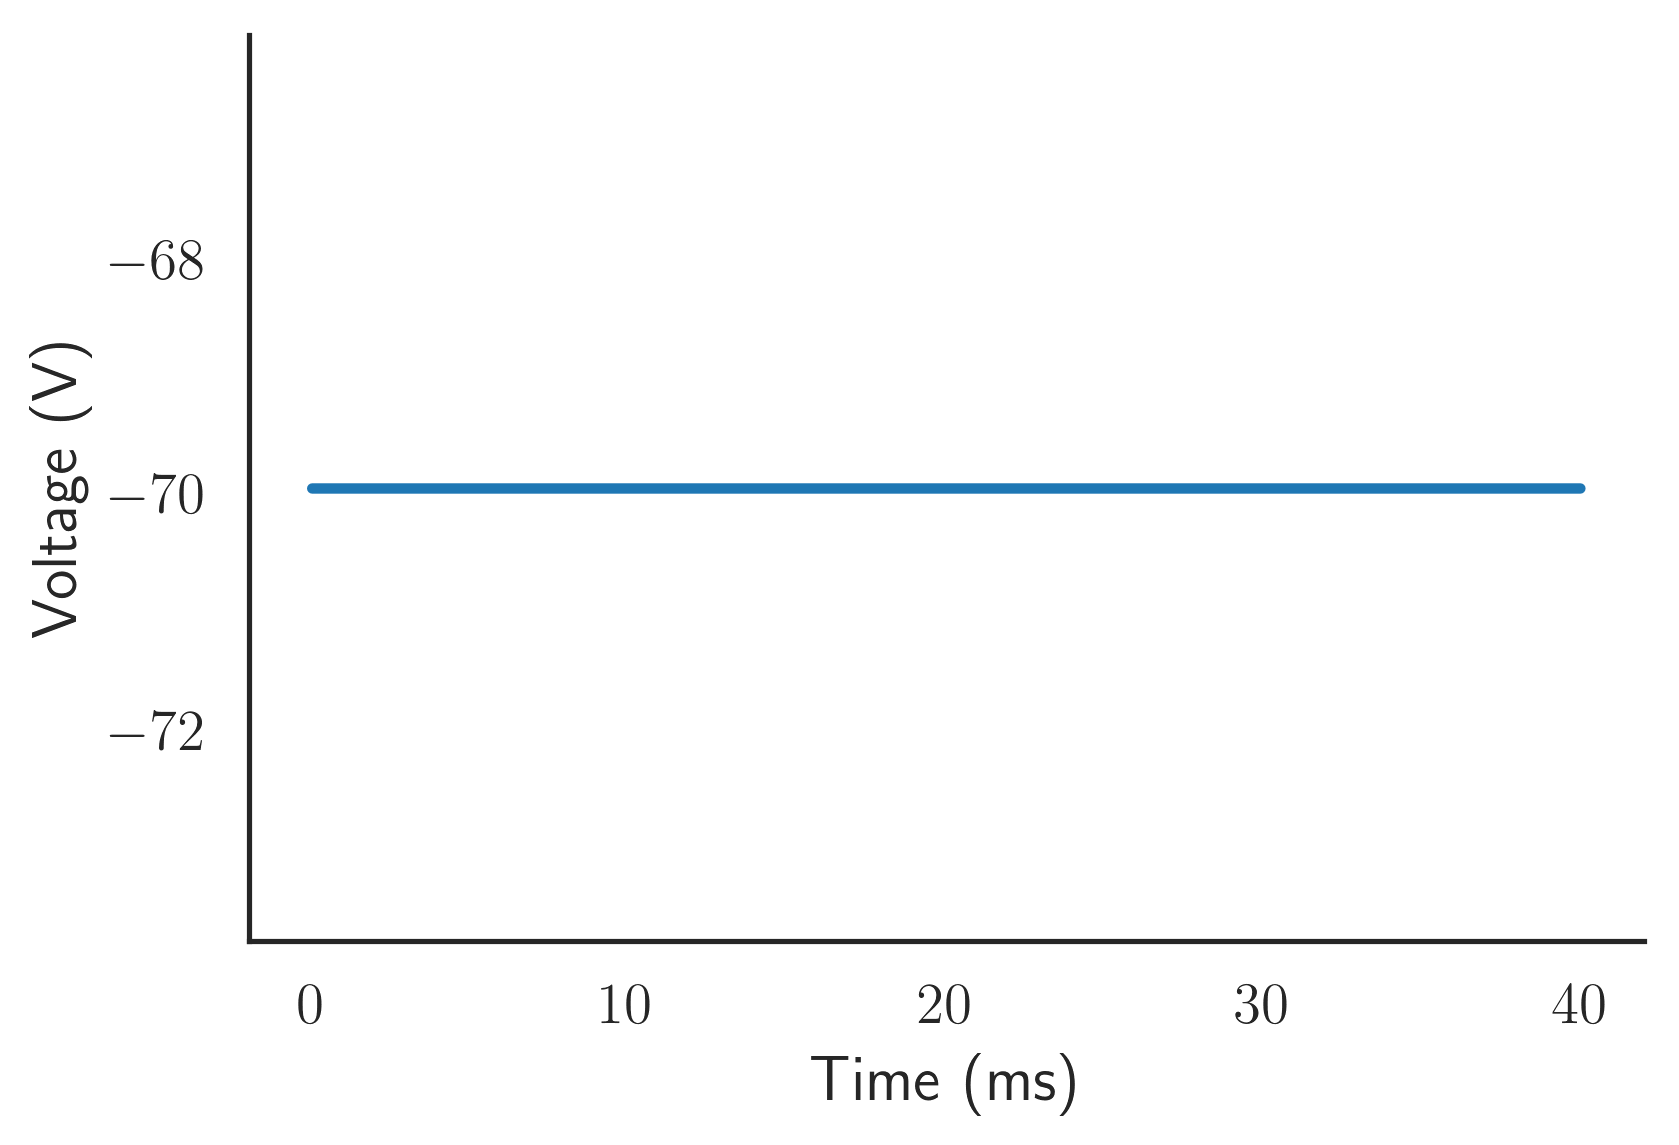

In [76]:
import seaborn as sns
# make alpha cell 
alpha_cell = make_alpha_cell(alphaLocation = 0.5, onset = 20, gmax = 1, printProperties = False)
voltage, time = measure_V(cell = alpha_cell, printProperties = True)

# aesthetics()
ax = sns.lineplot(time, voltage)
ax.set(xlabel='Time (ms)', ylabel='Voltage (mV)')
sns.despine()

We define a function which creates a cell with soma, dendrites and passive properties. The function add an excitatory alphasynapse at a specified location on the dendrite runs the simulation whilst recording voltage at the soma and time. 

Recording at the soma


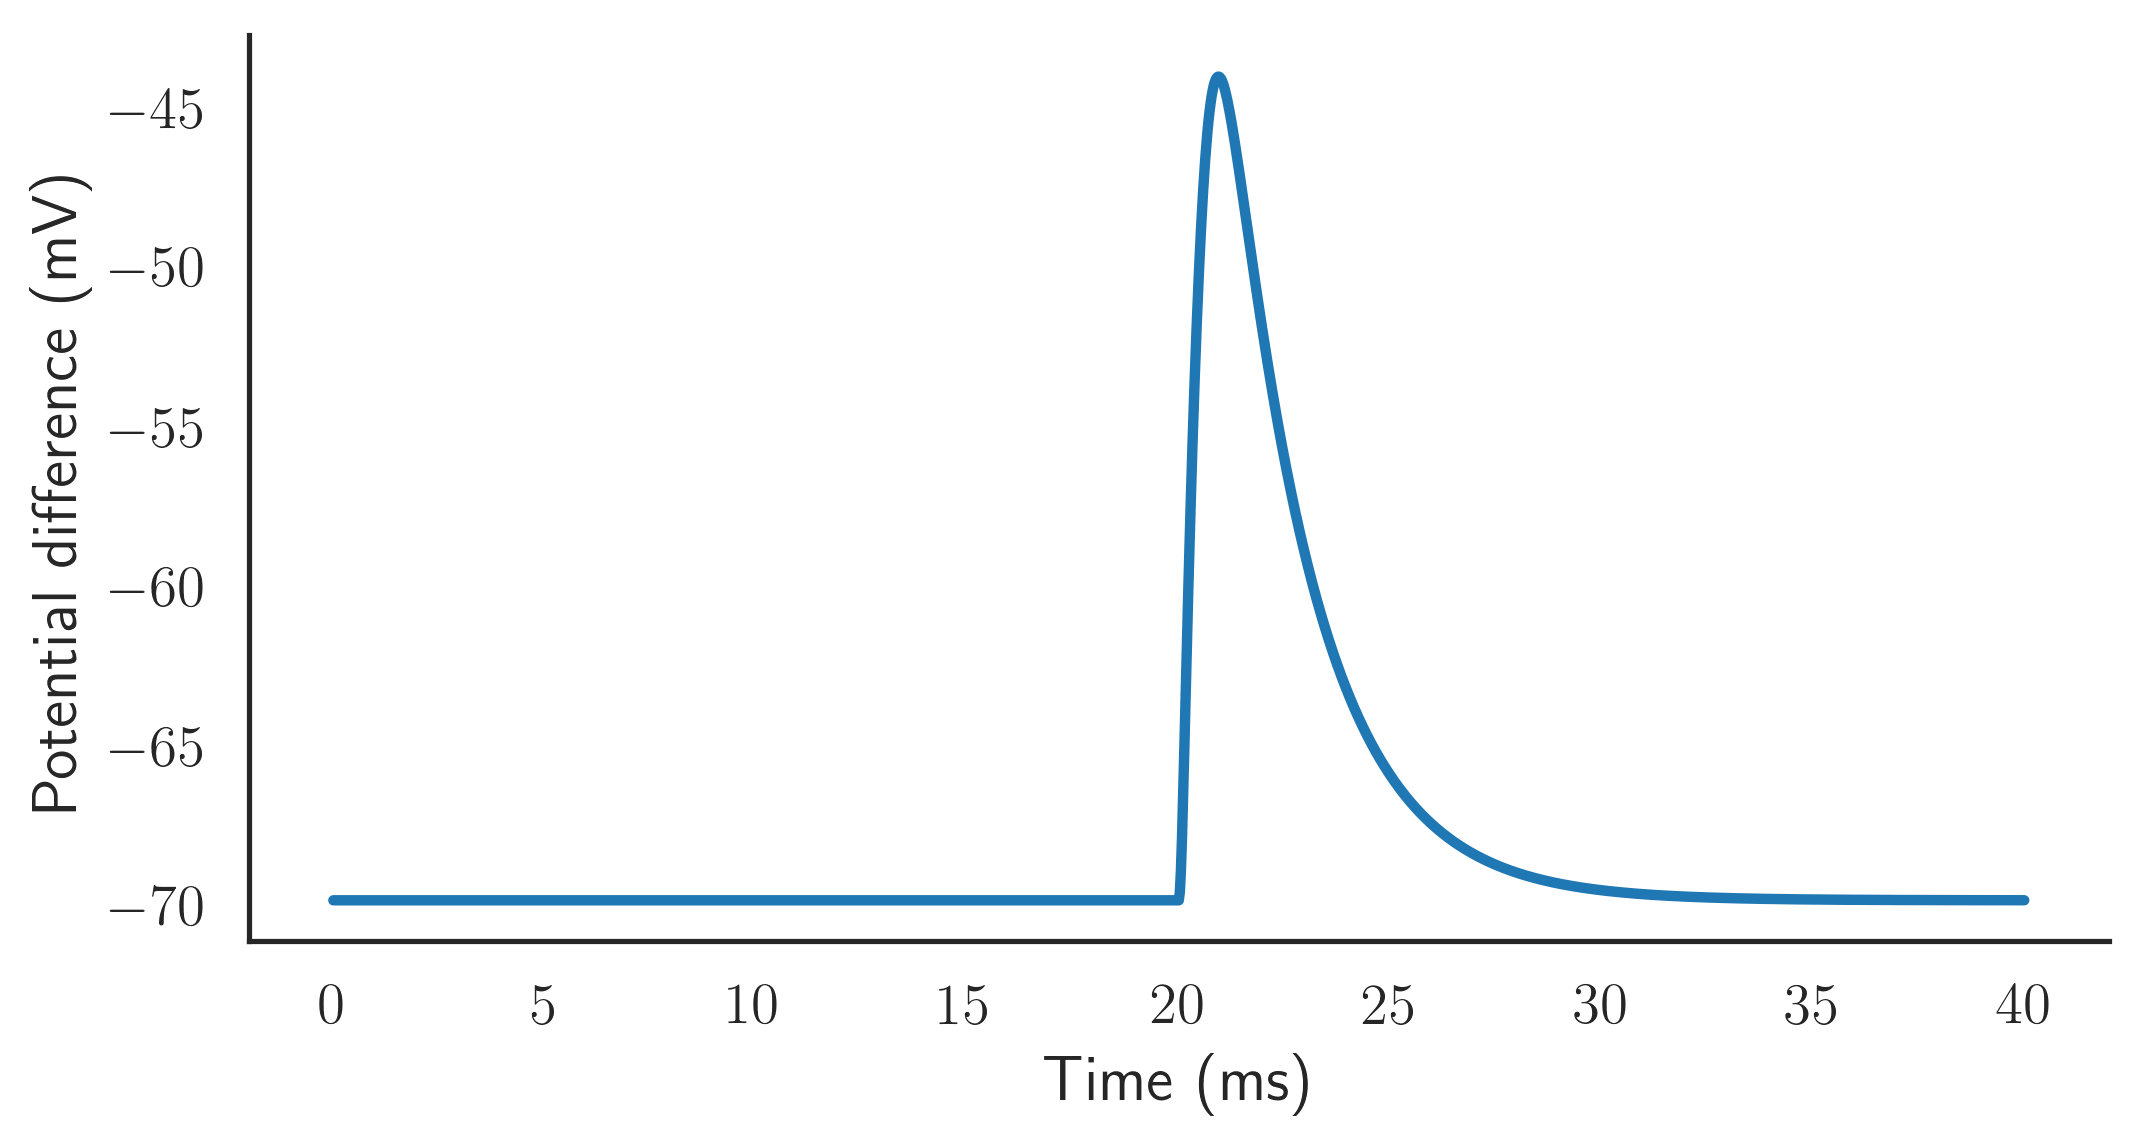

In [28]:
%reset -f 
from neuron import h, gui
import seaborn as sns 
import matplotlib.pyplot as plt

def sim_alpha_synapse(alpha_loc = 0.5, record_loc = 0.5, simDur = 40, vInit = -70, 
                      alpha_onset = 20, alpha_gmax = 1, printProperties = False, nSomaSegment = 1, 
                      nDendSegment = 300,
                     somaLength = 1000, recordSegment = 'soma', 
                      dendriteNum = 0):
    """
    Create alpha synapse, then simulate to record potential difference over time
    INPUT 
    alpha_loc  | location of inserting alpha syanapse 
    record_loc | location of recording the alpha synapse
    simDur     | duration of the simulation (ms)
    """
    soma = h.Section(name='soma')
    soma.insert('pas')
    
    soma.L = 20 #somaLength
    soma.diam = 20 #
    
    # alpha synapse on soma
    # soma.nseg = nSomaSegment
    # asyn = h.AlphaSynapse(soma(alpha_loc))
    
    # alpha synapse on dendrite 
    dend = h.Section(name = 'dend')
    dend.L = 300
    dend.diam = 1
    dend.nseg = nDendSegment 
    asyn = h.AlphaSynapse(dend(alpha_loc))
    dend.connect(soma(0))
    
    asyn.onset = alpha_onset
    asyn.gmax = alpha_gmax
    
    
    if printProperties is True: 
        h.psection(soma)
        h.psection(dend)
        # print(dir(asyn))
    
    v_vec = h.Vector()             # Membrane potential vector
    t_vec = h.Vector()             # Time stamp vector
    if recordSegment == 'soma':
        # print('Recording at the soma')
        v_vec.record(soma(record_loc)._ref_v)
    elif recordSegment == 'dendrite':
        # print('Recording at the dendrite')
        v_vec.record(dend(record_loc)._ref_v)
    t_vec.record(h._ref_t)
    h.v_init = vInit
    h.tstop = simDur
    h.run()
    return t_vec, v_vec

time, voltage = sim_alpha_synapse()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4)) # Default figsize is (8,6)
plt.plot(time, voltage)
plt.xlabel('Time (ms)')
plt.ylabel('Potential difference (mV)')
plt.show()

### Moving the alpha synapse progressively far away 

0.1
Recording at the soma
0.2
Recording at the soma
0.3
Recording at the soma
0.4
Recording at the soma
0.5
Recording at the soma


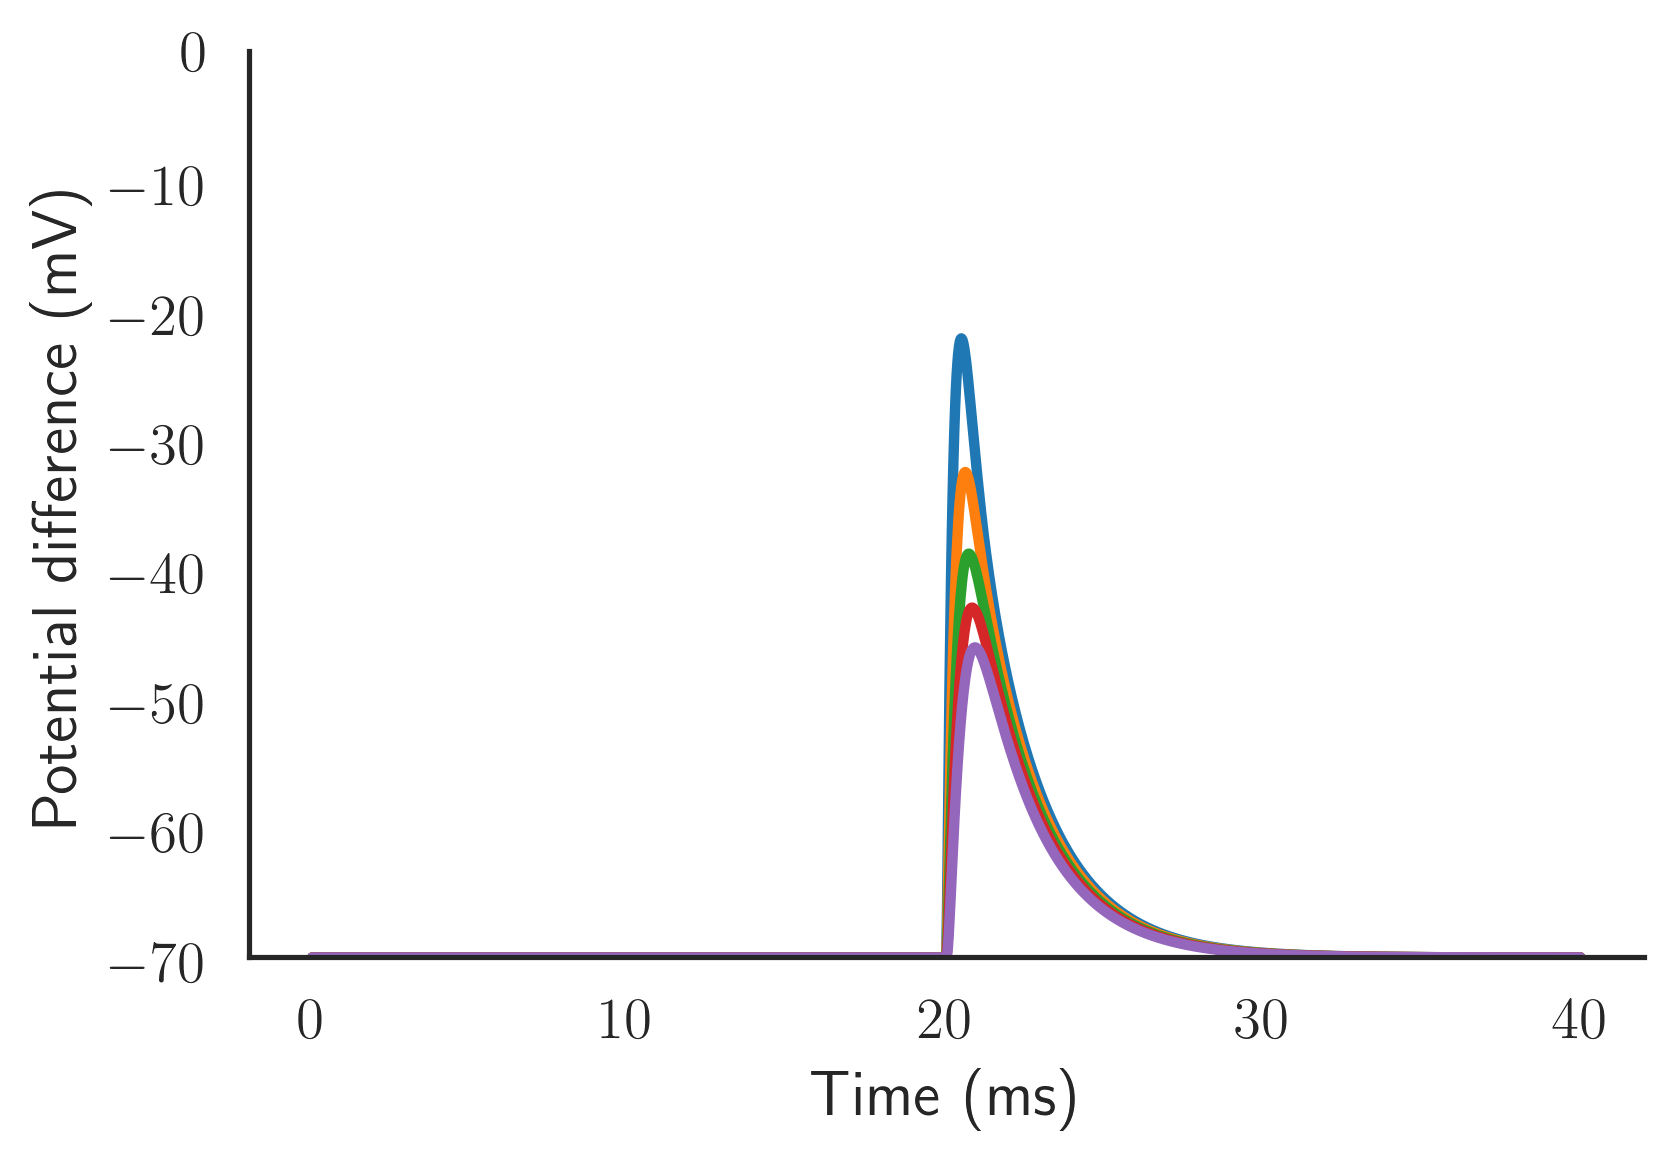

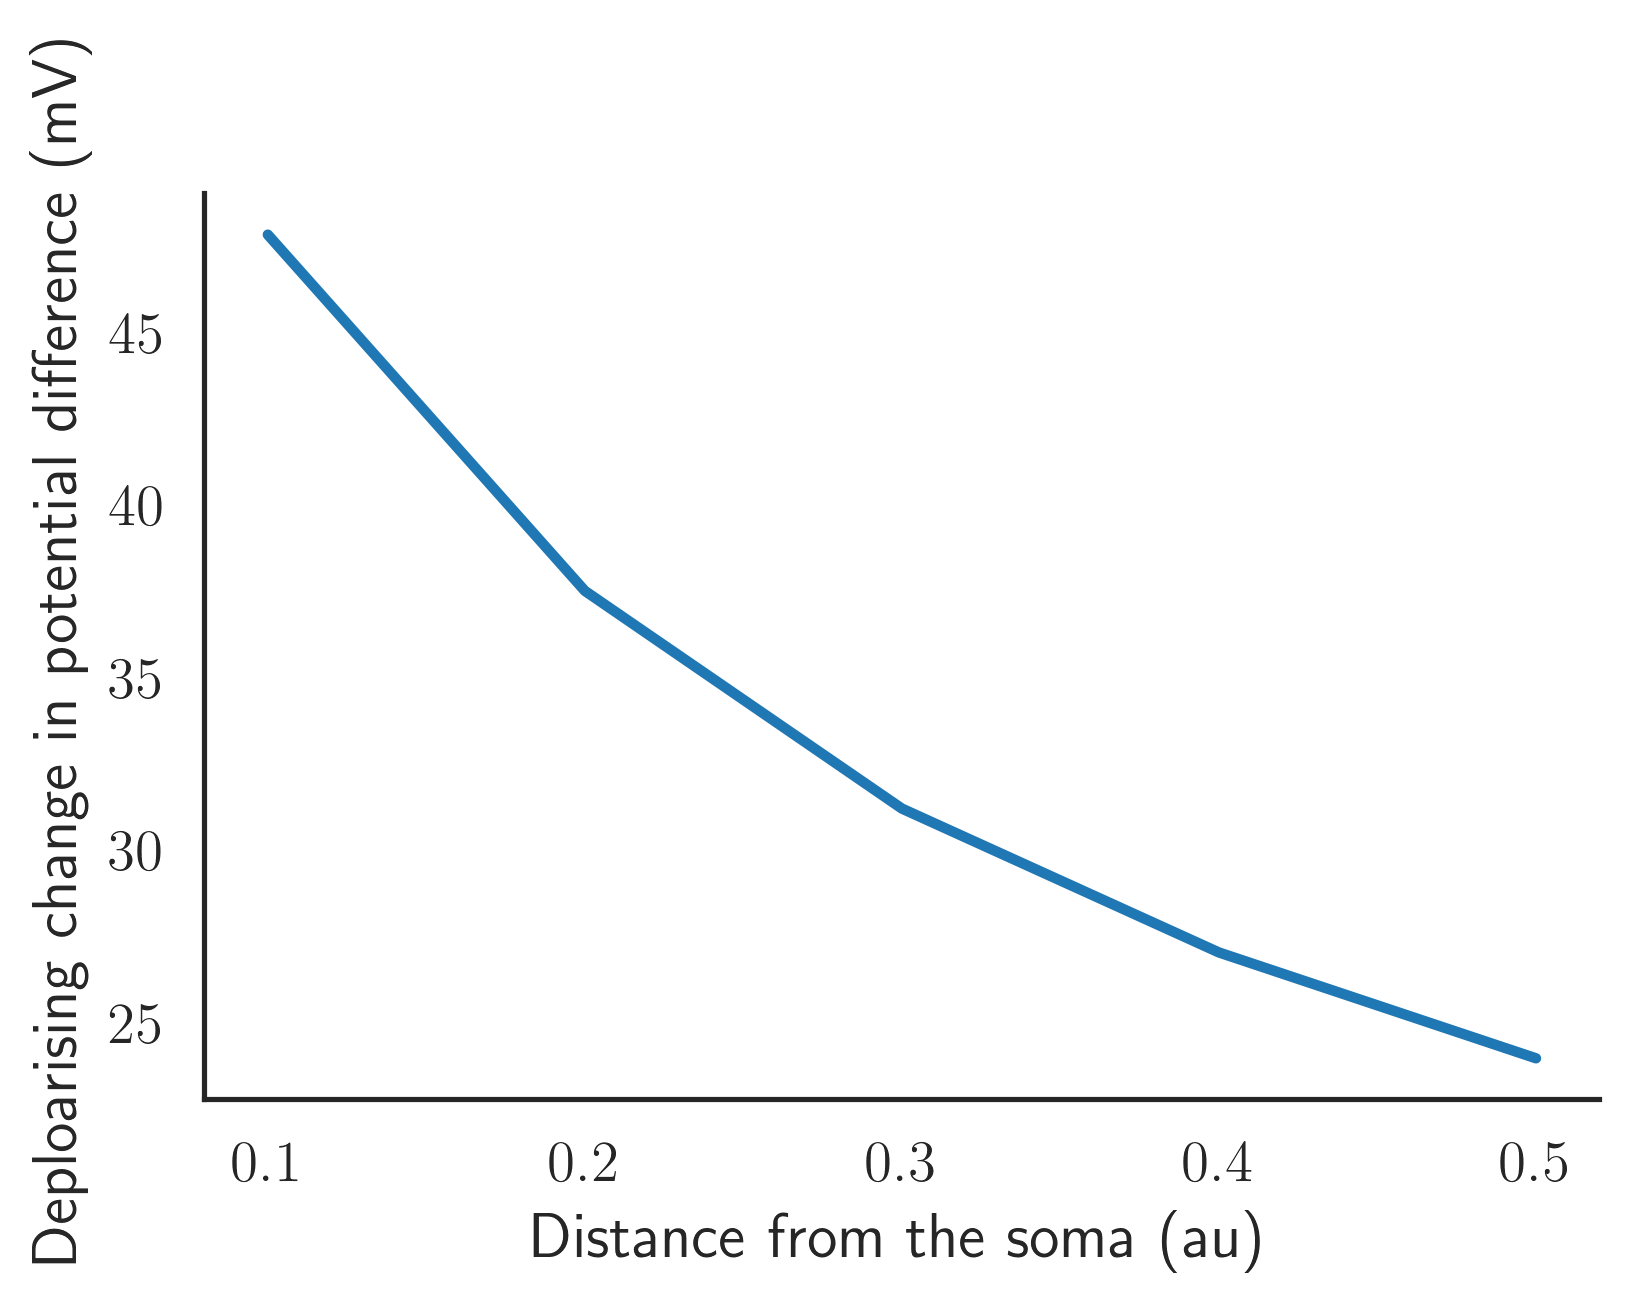

In [33]:
# progressively far away alpha synapse 
location_list = [0.1, 0.2, 0.3, 0.4, 0.5]
alpha_onset_list = [1, 5, 10, 15, 20]
peak_voltage = []


for loc in location_list:
    print(loc)
    time, voltage = sim_alpha_synapse(alpha_loc = loc, record_loc = 0.5, simDur = 40, 
                                      nSomaSegment = 100, somaLength = 1000,
                                      alpha_gmax = 0.5, 
                                      printProperties = False)
    sns.lineplot(time, voltage)
    peak_voltage.append(max(voltage) - min(voltage))
    plt.xlabel('Time (ms)')
    plt.ylabel('Potential difference (mV)')

plt.ylim([-70, 0])
plt.show()

# TODO add legend
# plt.legend()

"""
for alpha_onset in alpha_onset_list:
    time, voltage = sim_alpha_synapse(alpha_loc = 0.5, record_loc = 0.5, simDur = 40, alpha_onset = alpha_onset, 
                                      printProperties = True)
    sns.lineplot(time, voltage)
    plt.xlabel('Time (ms)')
    plt.ylabel('Potential difference (mV)')
"""


# plot the peak potential difference against the distance 
plt.figure()
sns.lineplot(location_list, peak_voltage)
plt.ylabel('Deploarising change in potential difference (mV)')
plt.xlabel('Distance from the soma (au)')
plt.show()

As expected we see that the amplitude of the voltage change elicted by the alphasynapse decreases with distance due to the passive properties of the cell. As a result when the alphasynapse is further away from the some the depolarising change recorded as the soma is smaller then when it is closer to the soma.

## Record at the dendrite where the synapse is whilst moving the alpha synapse progressively far away

0.1
Recording at the dendrite
0.2
Recording at the dendrite
0.3
Recording at the dendrite
0.4
Recording at the dendrite
0.5
Recording at the dendrite


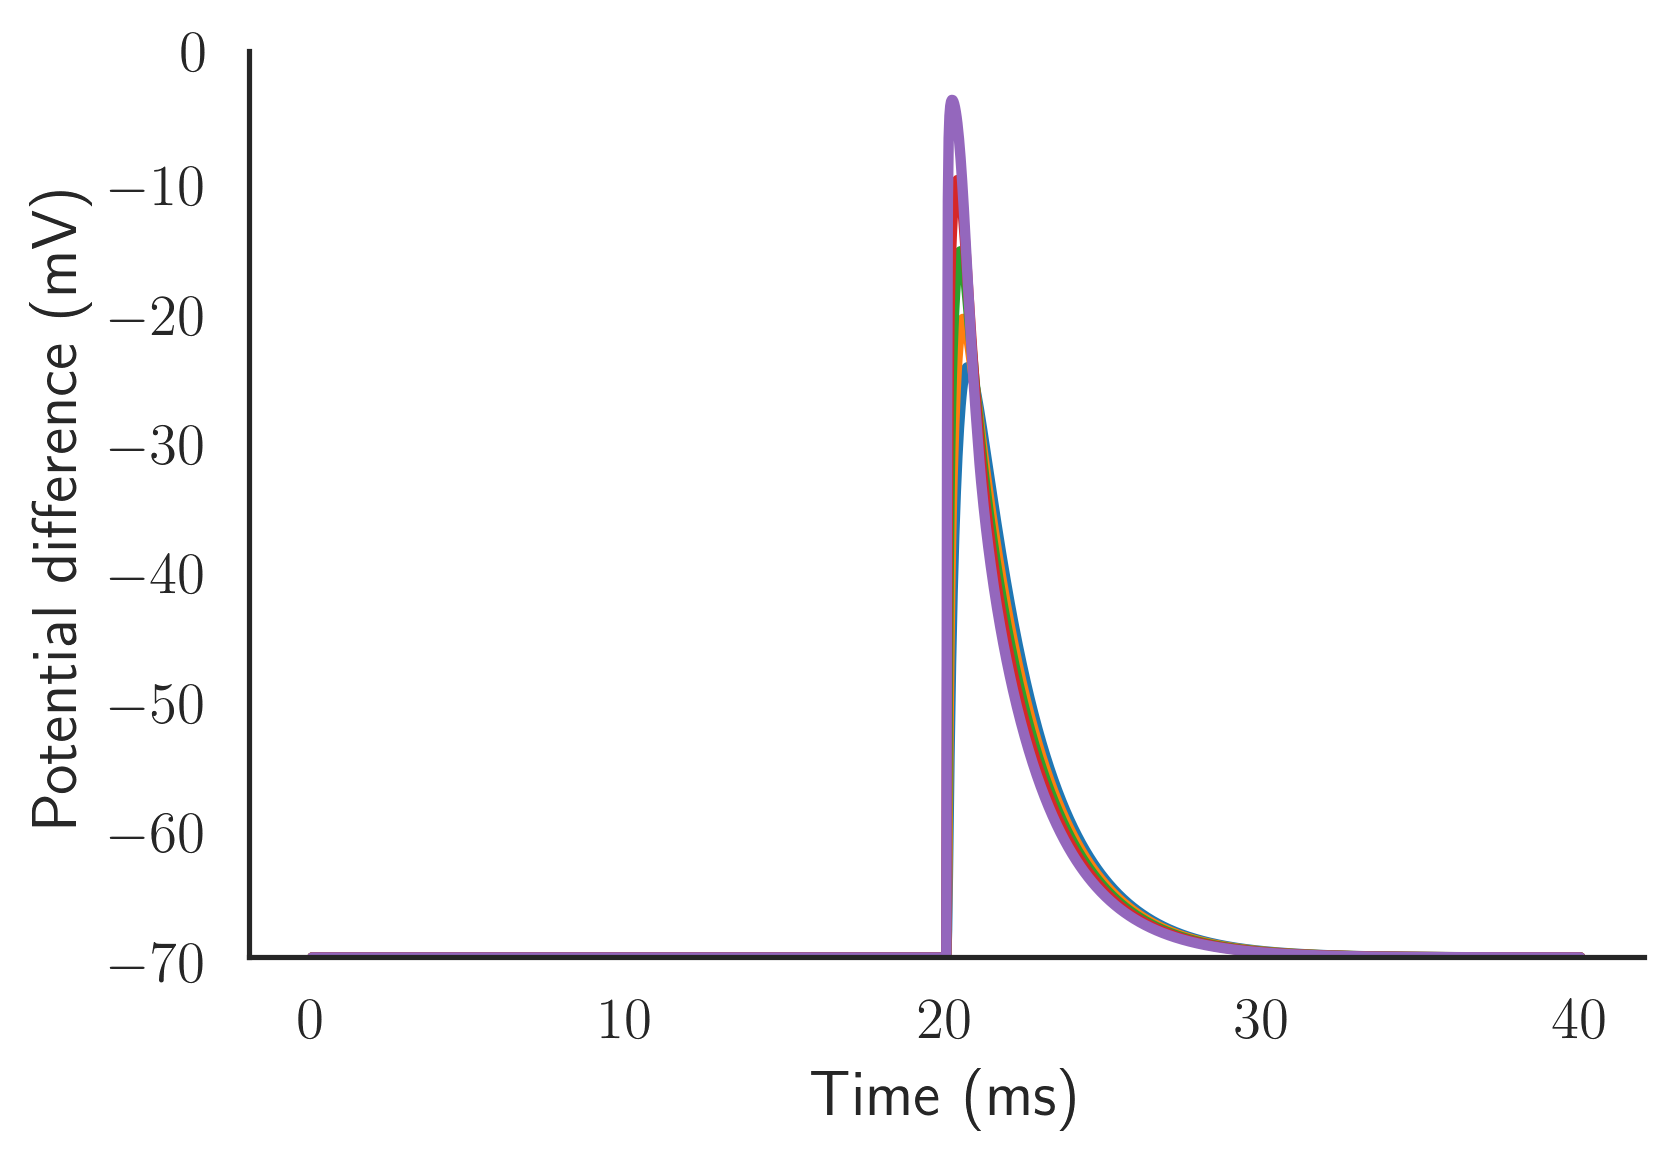

In [34]:
location_list = [0.1, 0.2, 0.3, 0.4, 0.5]
for loc in location_list:
    print(loc)
    time, voltage = sim_alpha_synapse(alpha_loc = loc, record_loc = 0.5, simDur = 40, 
                                      nSomaSegment = 100, somaLength = 1000,
                                      alpha_gmax = 0.5, recordSegment = 'dendrite',
                                      printProperties = False)
    sns.lineplot(time, voltage)
    # peak_voltage.append(max(voltage) - min(voltage))
    plt.xlabel('Time (ms)')
    plt.ylabel('Potential difference (mV)')

plt.ylim([-70, 0])
plt.show()


When we record the voltage at the dendrite as the alphasynapse is activated we observe that the size of the voltage change is higher than when the synapse was on near the soma. The high voltage change is due to the dendrites smaller size. 

|-|       soma(0-1)
   `|       dend1(0-1)
     `|       dend2(0-1)
       `|       dend3(0-1)

Adding to dend1
Adding to dend2
Adding to dend3
[]


'\nfor something in something:\n    asyn = h.AlphaSynapse(soma(alpha_loc))\n    asyn.onset = alpha_onset\n    asyn.gmax = alpha_gmax\n'

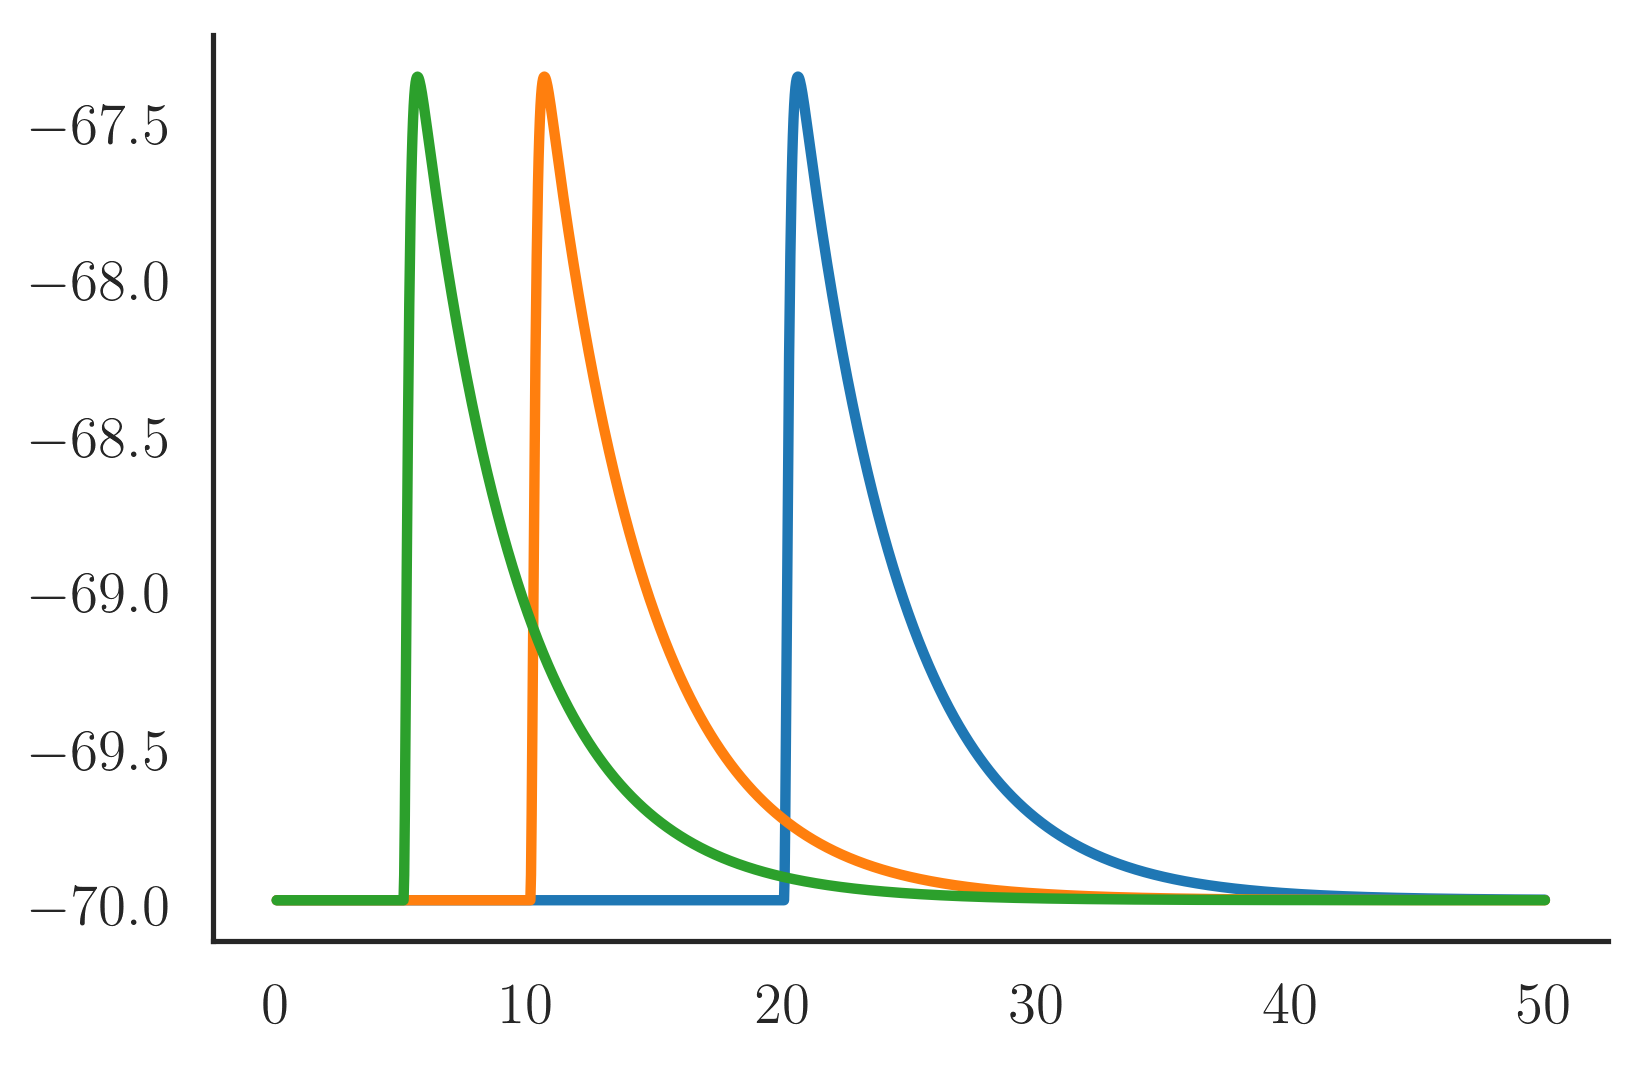

<Figure size 1800x1200 with 0 Axes>

In [147]:
soma = h.Section(name='soma')
soma.insert('pas')

soma.L = 100

time_list = list()
voltage_list = list()

dend1 = h.Section(name = 'dend1')
dend2 = h.Section(name = 'dend2')
dend3 = h.Section(name = 'dend3')

dend1.connect(soma(1))
dend2.connect(dend1(1))
dend3.connect(dend2(1))

h.topology() 

dend_list = list(['dend1', 'dend2', 'dend3'])
asyn_onset_list  = [5, 10, 20]

for loc in dend_list:
    if loc == 'dend1':
        print('Adding to dend1')
        asyn = h.AlphaSynapse(dend1(0.5))
        asyn.onset = 20
    elif loc == 'dend2':
        print('Adding to dend2')
        asyn = h.AlphaSynapse(dend2(0.5))
        asyn.onset = 10
    elif loc == 'dend3':
        print('Adding to dend3')
        asyn = h.AlphaSynapse(dend3(0.5))
        asyn.onset = 5
        
    # asyn.onset = 20
    asyn.gmax = 1
    
    v_vec = h.Vector()             # Membrane potential vector
    t_vec = h.Vector()             # Time stamp vector
    v_vec.record(soma(0.5)._ref_v)
    t_vec.record(h._ref_t)
    h.v_init = -70
    h.tstop = 50
    h.run()
    
    # time_list.append(t_vec)
    # voltage_list.append(v_vec)
    plt.plot(t_vec, v_vec)
    

print(voltage_list)
    
plt.figure()
for voltage_vec in voltage_list:
    plt.plot(time_list[0], voltage_vec)
    print(voltage_vec)
    # sns.lineplot(time_list[0], voltage_vec)


"""
for something in something:
    asyn = h.AlphaSynapse(soma(alpha_loc))
    asyn.onset = alpha_onset
    asyn.gmax = alpha_gmax
"""





## Change $R_m$, $C_m$ and $R_a$, how does it affect the EPSP locally and at the soma?

### Effect of variables on EPSP at the dendrite

In [24]:
%reset -f
from neuron import h, gui
import seaborn as sns
import matplotlib.pyplot as plt 
Ra_list = [10, 20, 30, 40, 50]
# diam_list = [500, 600, 700, 800, 900]
Cm_list = [1, 2, 3, 4, 5]
Rm_list = [1000, 2000, 3000, 4000]

def sim_alpha_dendrite(alpha_loc = 0.5, record_loc = 0.5, simDur = 40, vInit = -70, 
                      alpha_onset = 20, alpha_gmax = 1, printProperties = False, nSomaSegment = 1, 
                     somaLength = 1000,
                      dendriteNum = 0, dendLength = 10, dendCm = 1, dendRa = 10, dendRm = 1, dendE = -65,
                      recordSection = 'soma'):
    """
    Create alpha synapse on dendrite, then simulate to record potential difference over time
    INPUT 
    alpha_loc  | location of inserting alpha syanapse 
    record_loc | location of recording the alpha synapse
    simDur     | duration of the simulation (ms)
    """
    soma = h.Section(name='soma')
    soma.insert('pas')
    
    dend = h.Section(name='dendrite')
    
    dend.connect(soma(0))
    
    soma.L = somaLength

    # soma.nseg = nSomaSegment
    
    # dendrite properties
    dend.L = dendLength
    dend.Ra = dendRa
    dend.cm = dendCm
    
    dendConductance = 1 / dendRm
    # Insert passive current in the dendrite
    dend.insert('pas')
    for seg in dend:
        seg.pas.g = dendConductance  # Passive conductance in S/cm2
        seg.pas.e = dendE    # Leak reversal potential mV
    

    asyn = h.AlphaSynapse(dend(alpha_loc))
    asyn.onset = alpha_onset
    asyn.gmax = alpha_gmax
    
    
    if printProperties is True: 
        h.psection(dend)
        h.topology
        # print(dir(asyn))
    
    v_vec = h.Vector()             # Membrane potential vector
    t_vec = h.Vector()             # Time stamp vector
    if recordSection == 'soma':
        v_vec.record(soma(record_loc)._ref_v)
    elif recordSection == 'dend':
        v_vec.record(dend(record_loc)._ref_v)
    
    h.v_init = -65 # initial voltage
    
    t_vec.record(h._ref_t)
    h.v_init = vInit
    h.tstop = simDur
    h.run()
    return t_vec, v_vec

soma { nseg=1  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}
soma { nseg=1  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}
soma { nseg=1  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}
soma { nseg=1  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}
soma { nseg=1  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}


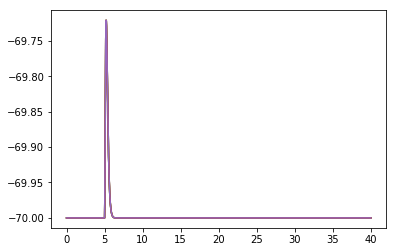

In [25]:
for Ra in Ra_list:
    time, voltage = sim_alpha_dendrite(alpha_onset = 5, dendRa = Ra, printProperties = True, recordSection = 'soma', dendE = -70)
    sns.lineplot(time, voltage)

soma { nseg=1  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}
soma { nseg=1  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}
soma { nseg=1  L=1000  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert pas { g_pas=0.001 e_pas=-70}
}


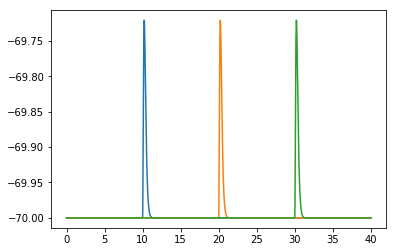

In [15]:
alpha_onset_list = [10, 20, 30]
for onset in alpha_onset_list:
    time, voltage = sim_alpha_dendrite(alpha_onset = onset, printProperties = True, recordSection = 'soma', dendE = -70)
    sns.lineplot(time, voltage)

In [43]:
onset_times = [0, 2, 5, 10, 20]
def alpha_synapse_tem(onset_times, activeProp = False, alpha_loc = 0.5, record_loc = 0.5, vInit = -70, 
                      simDur = 40, alpha_gmax = 1,
                      printProperties = False):
    """
    Creates a soma, then add a synapse that 'activates' in temporal intervals
    """
    soma = h.Section(name='soma')
    soma.insert('pas')
    
    for onset in onset_times:
        asyn = h.AlphaSynapse(soma(alpha_loc))
        asyn.onset = onset
    
    if printProperties is True: 
        h.psection(soma)
        h.topology
        # print(dir(asyn))
    
    if activeProp is True:
        soma.insert('hh')
    
    v_vec = h.Vector()             # Membrane potential vector
    t_vec = h.Vector()             # Time stamp vector
    v_vec.record(soma(record_loc)._ref_v)
    
    # h.v_init = -65 # initial voltage
    
    t_vec.record(h._ref_t)
    h.v_init = vInit
    h.tstop = simDur
    h.run()
    return t_vec, v_vec

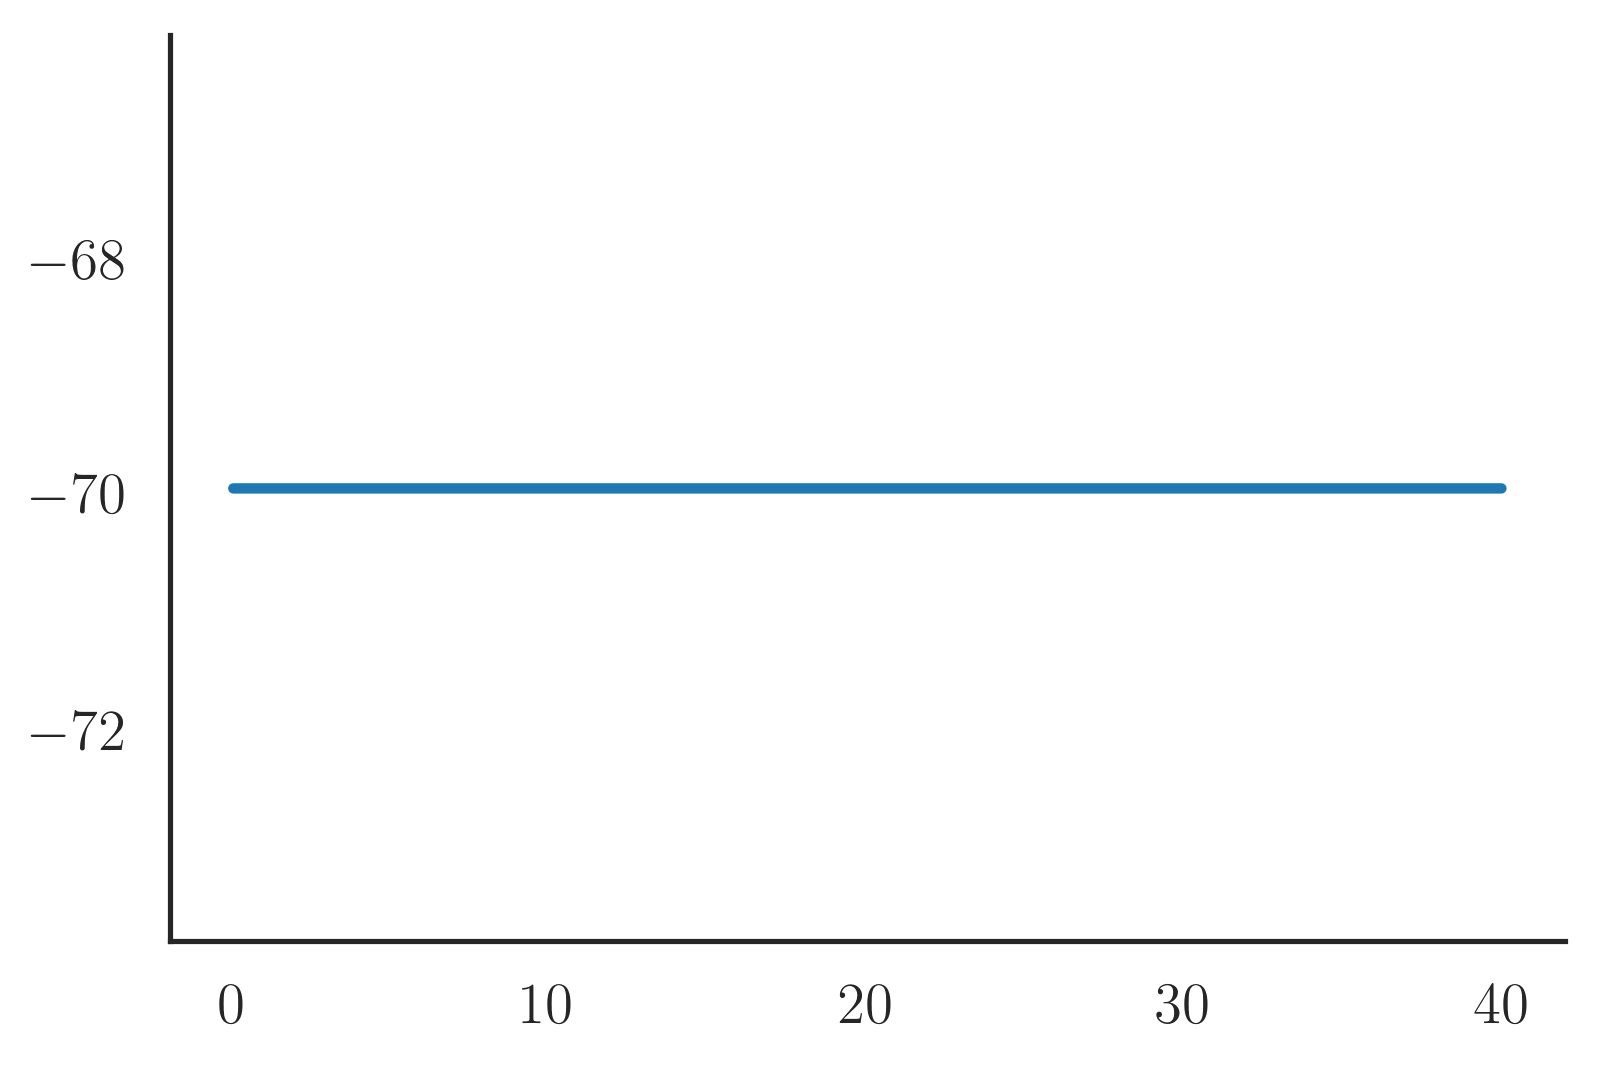

In [44]:
time, voltage = alpha_synapse_tem(onset_times, activeProp = False, alpha_loc = 0.5, record_loc = 0.5,
                                  simDur = 40, vInit = -70, alpha_gmax = 1,
                                  printProperties = False)
sns.lineplot(time, voltage)